In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LinearRegression,Lasso,RidgeCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import shap
from efficient_apriori import apriori
from plotnine import *
from warnings import filterwarnings
filterwarnings("ignore")



# Data cleaning

In [2]:
#load dataset
raw_data=pd.read_excel('raw_data.xlsx',sheet_name='Sheet3',index_col=0)
#raw_data.info()
df=raw_data.copy()

df['CSI_T']=np.where(df['CSI_T']=='—',np.nan,df['CSI_T'])
df['CSI_T']=df['CSI_T'].astype(float)

df['CSI_R']=np.where(df['CSI_R']=='—',np.nan,df['CSI_R'])
df['CSI_R']=df['CSI_R'].astype(float)

df['IPL_T']=np.where(df['IPL_T']=='—',np.nan,df['IPL_T'])
df['IPL_T']=df['IPL_T'].astype(float)

df['DOP_T']=np.where(df['DOP_T']=='—',np.nan,df['DOP_T'])
df['DOP_T']=df['DOP_T'].astype(float)

df['AT']=np.where(df['AT']=='—',np.nan,df['AT'])
df['AT']=df['AT'].astype(float)

#VOC
df['VOC']=np.where(df['VOC']=='—',np.nan,df['VOC'])
df['VOC']=df['VOC'].astype(float)
#JSC
df['JSC']=np.where(df['JSC']=='—',np.nan,df['JSC'])
df['JSC']=df['JSC'].astype(float)
#FF
df['FF']=np.where(df['FF']=='—',np.nan,df['FF'])
df['FF']=df['FF'].astype(float)
df['FF']=np.where(df['FF']<1,df['FF']*100,df['FF'])

df_na=df.copy()
#Fill in the missing values with the average
df['CSI_T']=df['CSI_T'].fillna(df['CSI_T'].mean())
df['CSI_R']=df['CSI_R'].fillna(df['CSI_R'].mean())
df['IPL_T']=df['IPL_T'].fillna(df['IPL_T'].mean())
df['DOP_T']=df['DOP_T'].fillna(df['DOP_T'].mean())
df['AT']=df['AT'].fillna(df['AT'].mean())

df['CSI_O']=df['CSI_O'].astype(str)
#Delete samples with missing values in the dependent variable
df=df.dropna(subset=['VOC','JSC','FF'])
df_eff_all=df.copy()
#Delete samples whose efficiency is less than 20
df=df[df['Eff']>20]

# Correlation analysis of independent variables

In [3]:
#The numerical variables are selected and the pearson correlation coefficient matrix is calculated
num_cols=['CSI_T','CSI_R','IPL_T','DOP_T','AT']
df_na[num_cols].corr(method='pearson')

,CSI_T,CSI_R,IPL_T,DOP_T,AT
CSI_T,1.000000,0.138991,-0.297054,-0.072817,-0.037546
CSI_R,0.138991,1.000000,-0.302807,0.042682,-0.142282
IPL_T,-0.297054,-0.302807,1.000000,0.145294,0.163914
DOP_T,-0.072817,0.042682,0.145294,1.000000,-0.020726
AT,-0.037546,-0.142282,0.163914,-0.020726,1.000000


<AxesSubplot:>

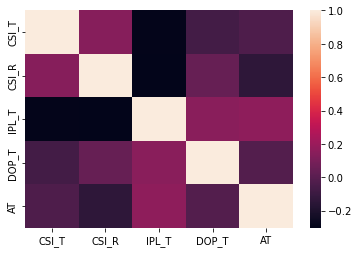

In [4]:
sns.heatmap(df_na[num_cols].corr(method='pearson'))

# Correlation analysis between dependent variables

In [5]:
#Pearson correlation coefficients between dependent variables 
df_na[['VOC', 'JSC', 'FF', 'Eff']].corr()

,VOC,JSC,FF,Eff
VOC,1.000000,0.372604,0.559078,0.756395
JSC,0.372604,1.000000,0.410663,0.795283
FF,0.559078,0.410663,1.000000,0.809034
Eff,0.756395,0.795283,0.809034,1.000000


<AxesSubplot:>

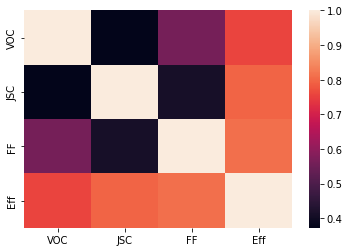

In [6]:
sns.heatmap(df_na[['VOC', 'JSC', 'FF', 'Eff']].corr())

In [7]:
#pearson correlation coefficient analysis of numerical independent variable and dependent variable
df_na[num_cols+['VOC', 'JSC', 'FF', 'Eff']].corr(method='pearson')

,CSI_T,CSI_R,IPL_T,DOP_T,AT,VOC,JSC,FF,Eff
CSI_T,1.000000,0.138991,-0.297054,-0.072817,-0.037546,-0.178133,-0.308520,-0.260507,-0.312181
CSI_R,0.138991,1.000000,-0.302807,0.042682,-0.142282,0.002522,0.075139,-0.021687,0.024133
IPL_T,-0.297054,-0.302807,1.000000,0.145294,0.163914,0.468502,0.366220,0.260994,0.437192
DOP_T,-0.072817,0.042682,0.145294,1.000000,-0.020726,0.181782,0.126775,0.096355,0.140226
AT,-0.037546,-0.142282,0.163914,-0.020726,1.000000,0.040599,-0.059021,0.019142,-0.007152
VOC,-0.178133,0.002522,0.468502,0.181782,0.040599,1.000000,0.372604,0.559078,0.756395
JSC,-0.308520,0.075139,0.366220,0.126775,-0.059021,0.372604,1.000000,0.410663,0.795283
FF,-0.260507,-0.021687,0.260994,0.096355,0.019142,0.559078,0.410663,1.000000,0.809034
Eff,-0.312181,0.024133,0.437192,0.140226,-0.007152,0.756395,0.795283,0.809034,1.000000


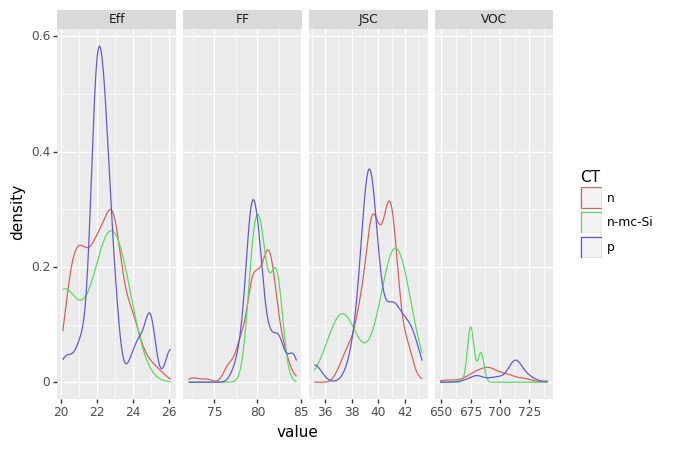

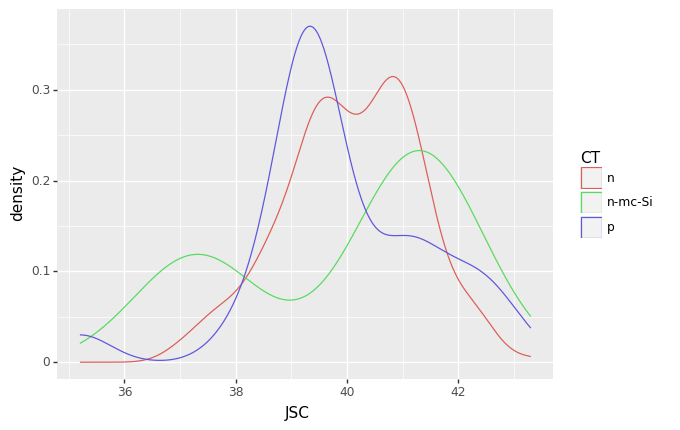

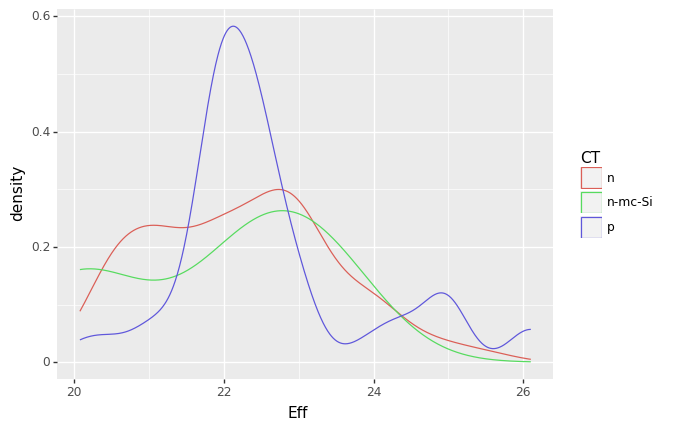

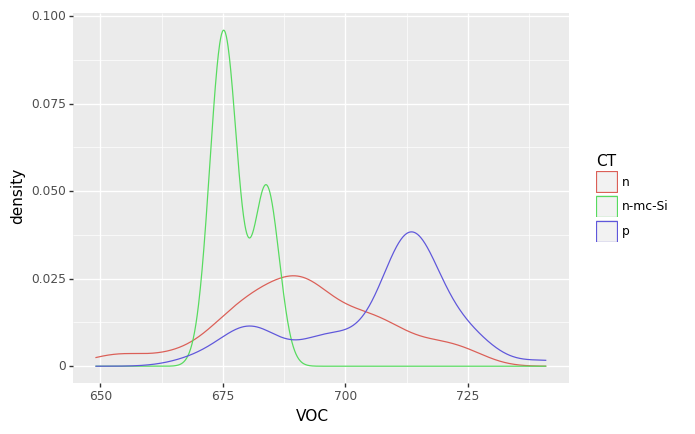

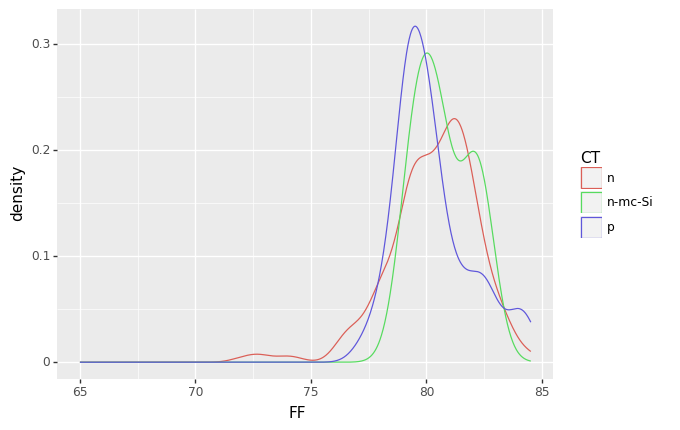

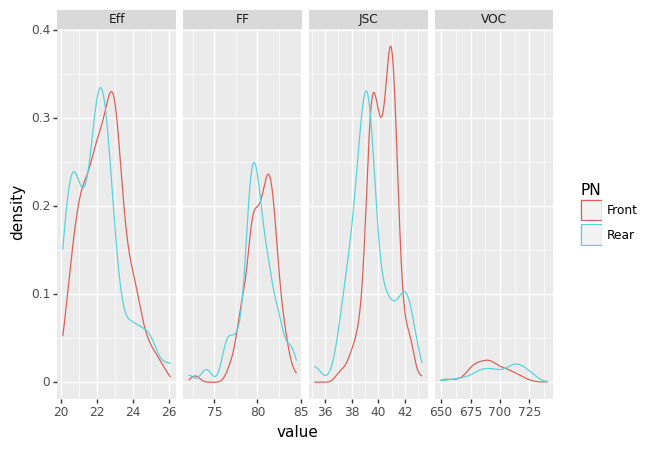

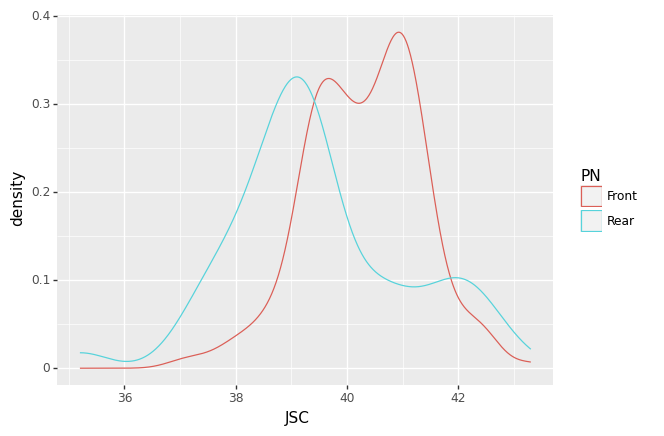

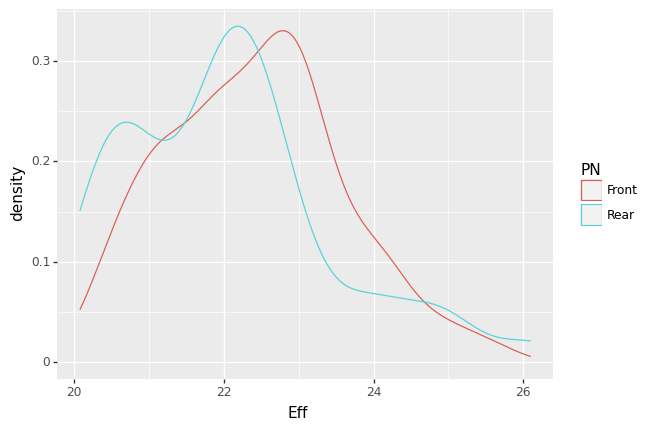

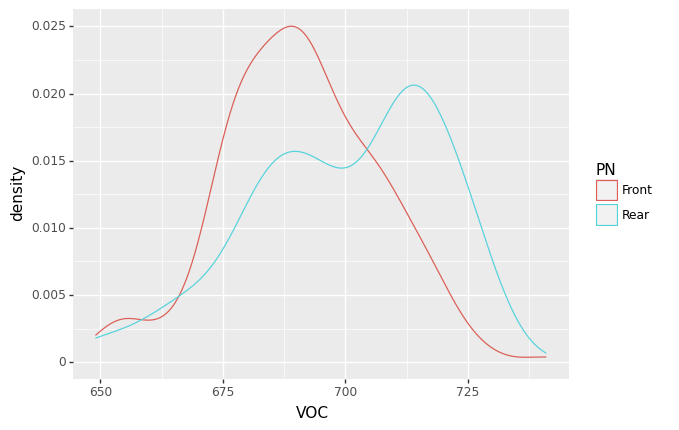

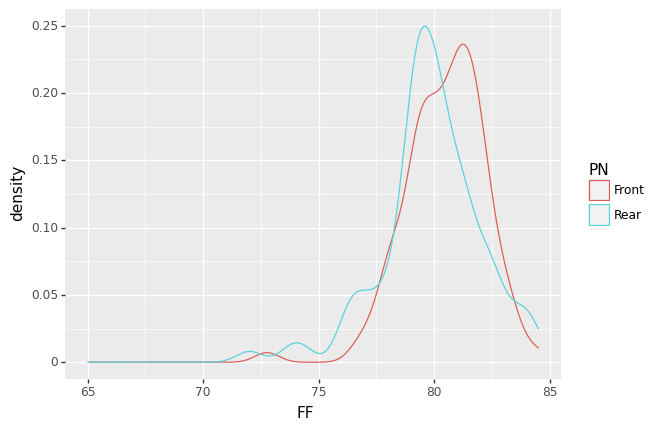

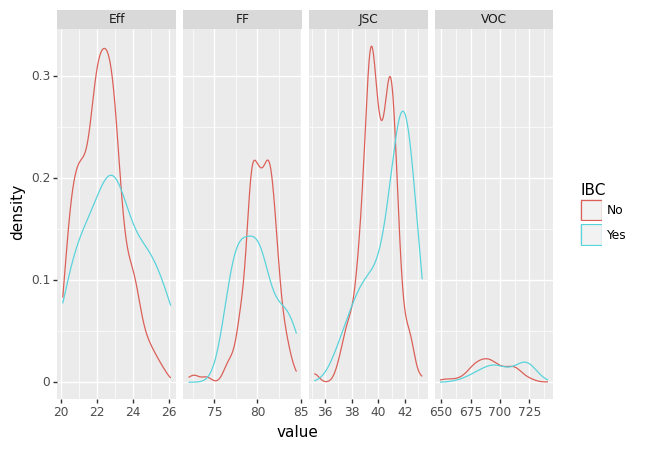

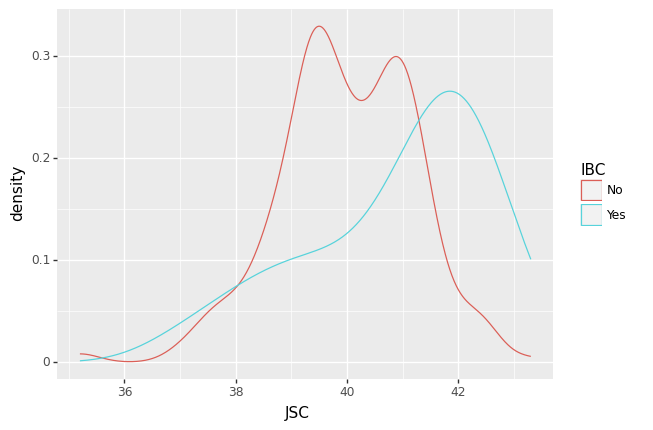

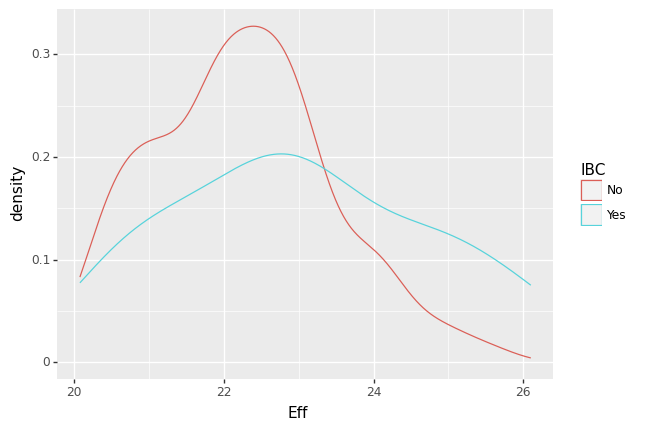

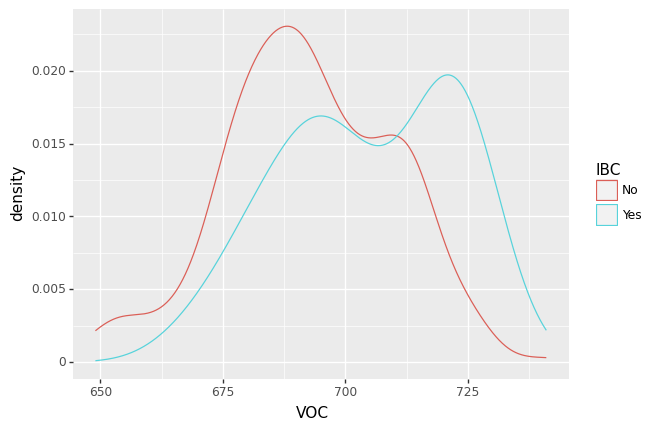

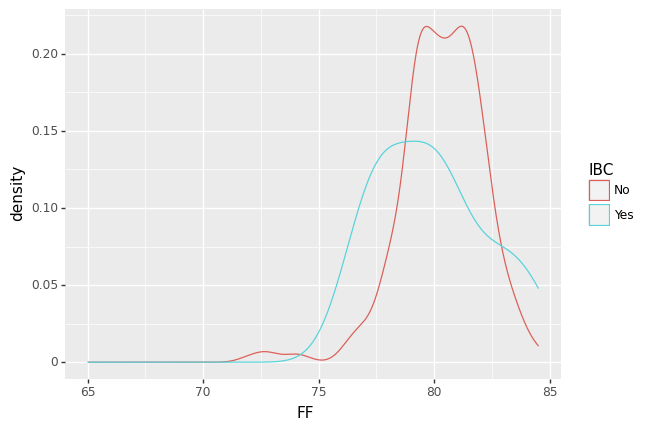

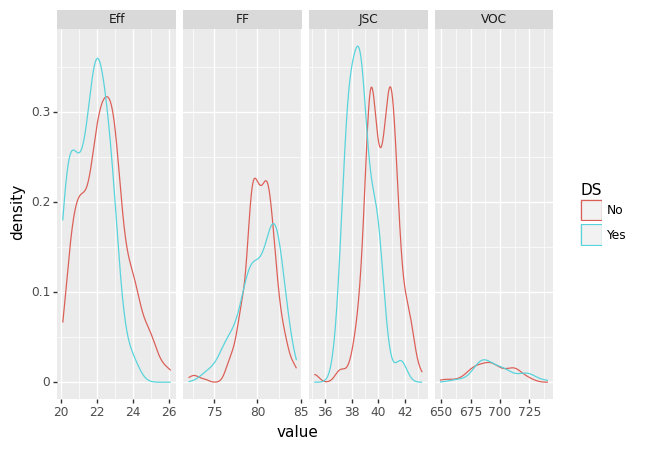

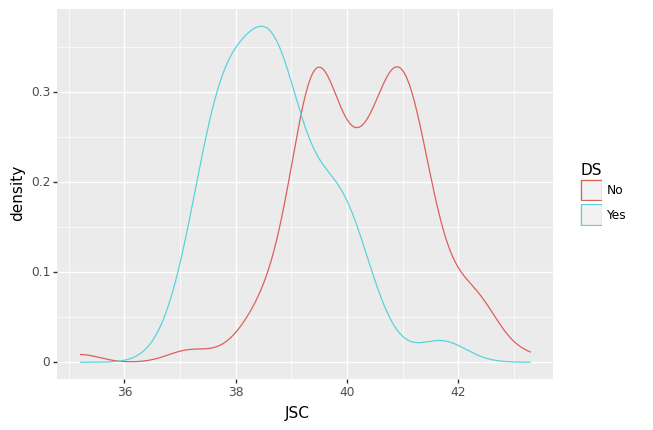

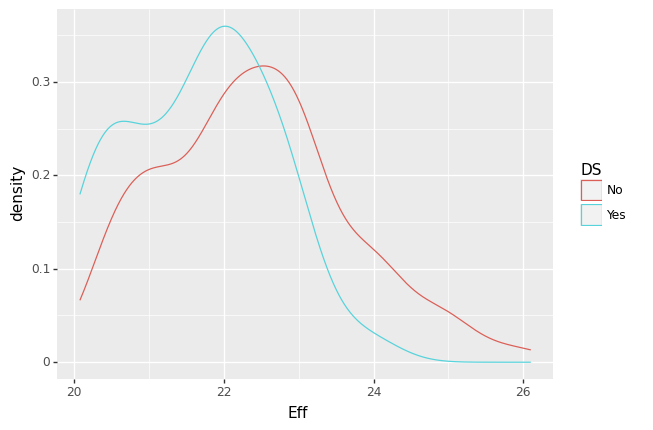

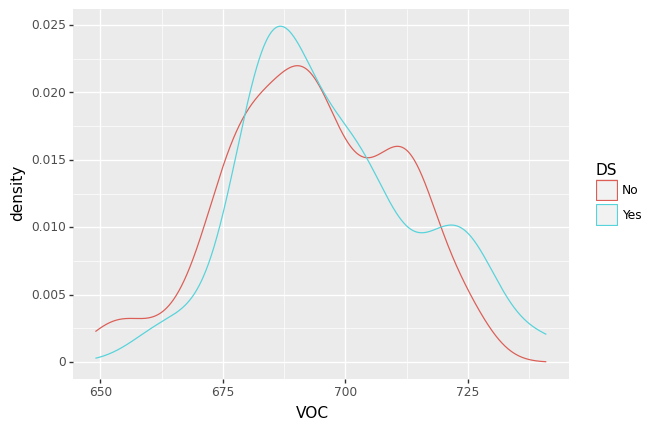

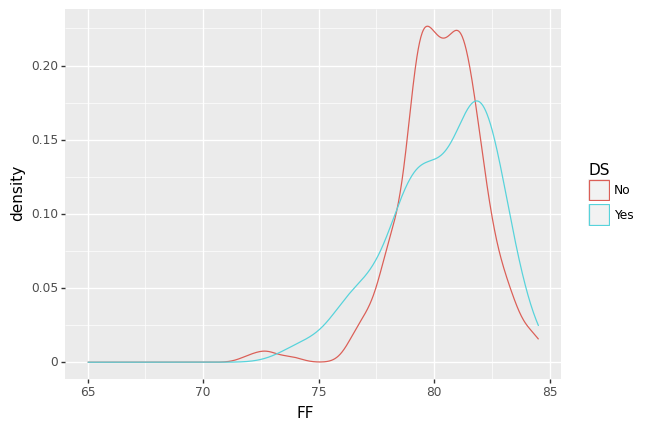

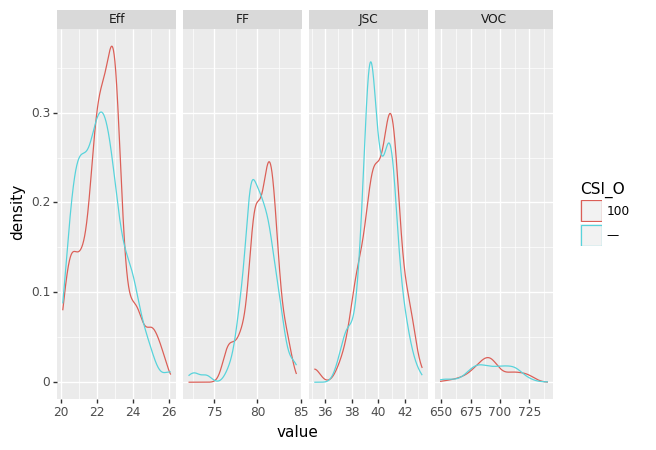

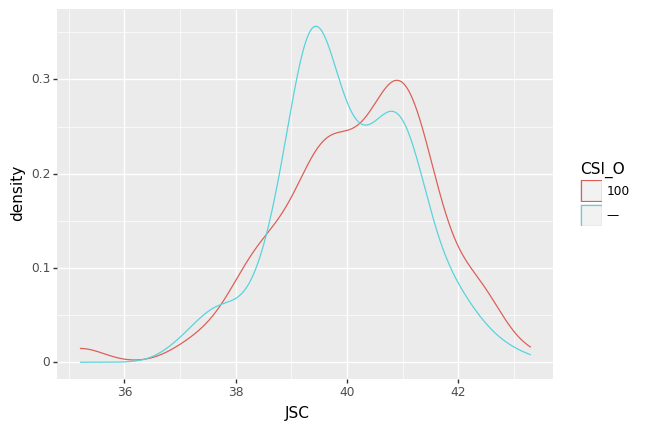

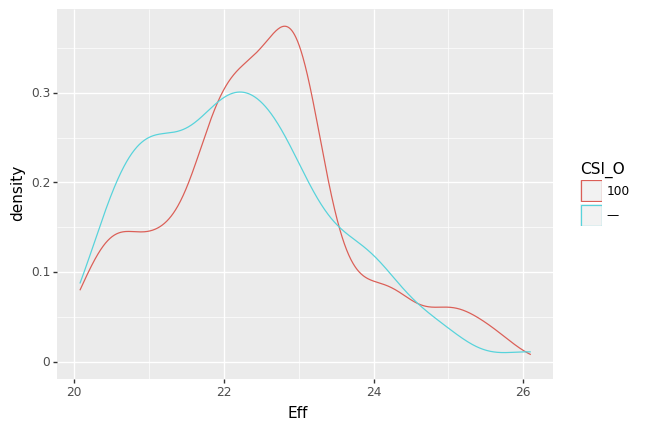

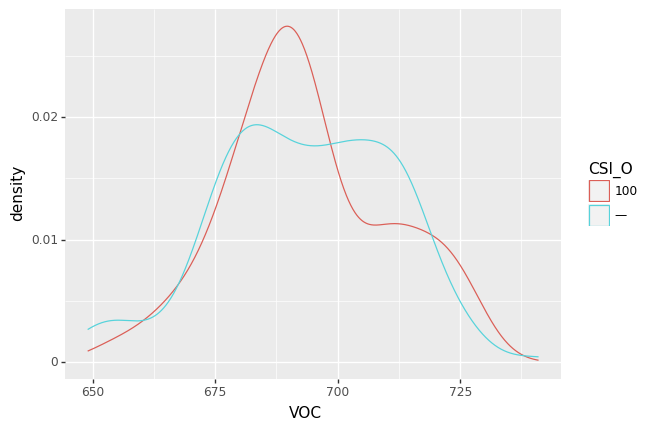

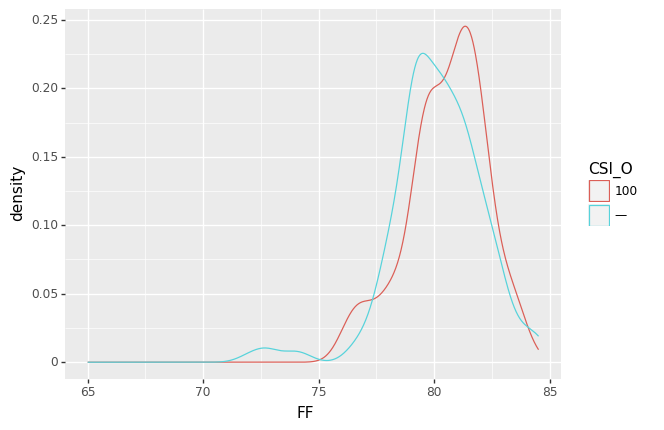

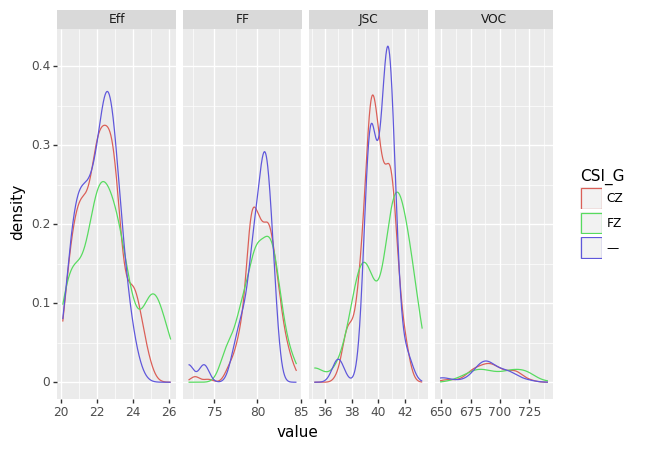

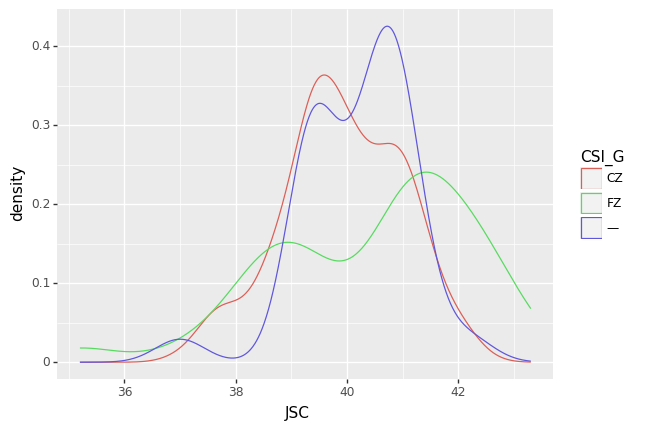

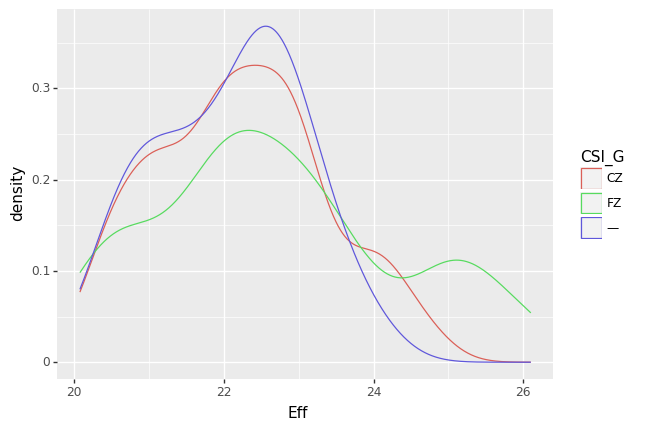

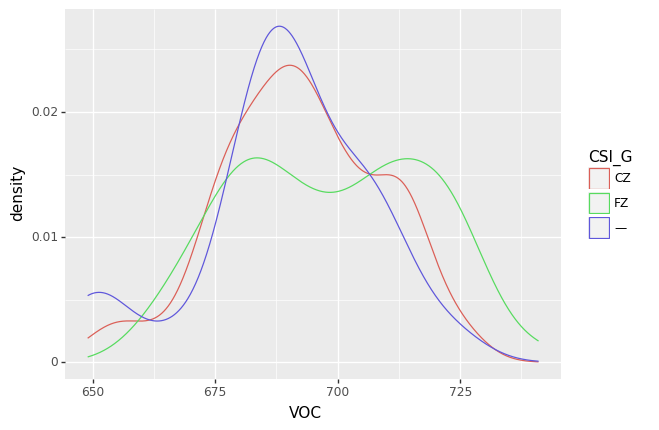

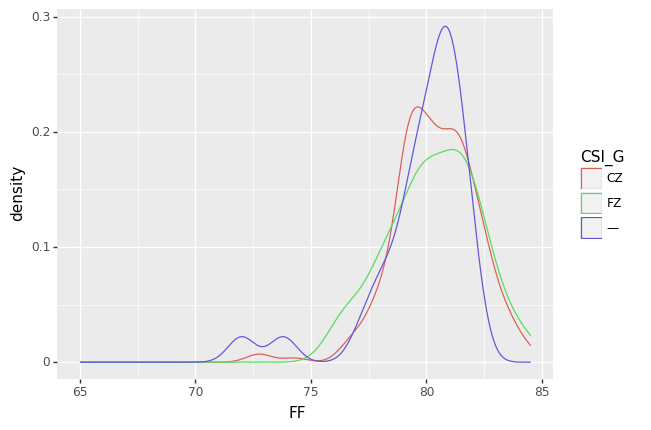

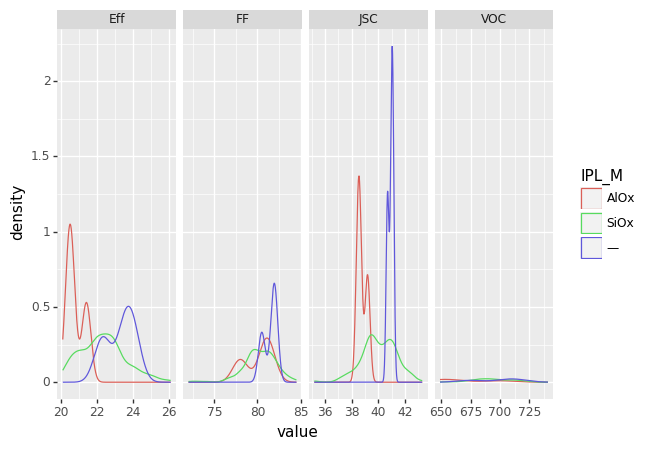

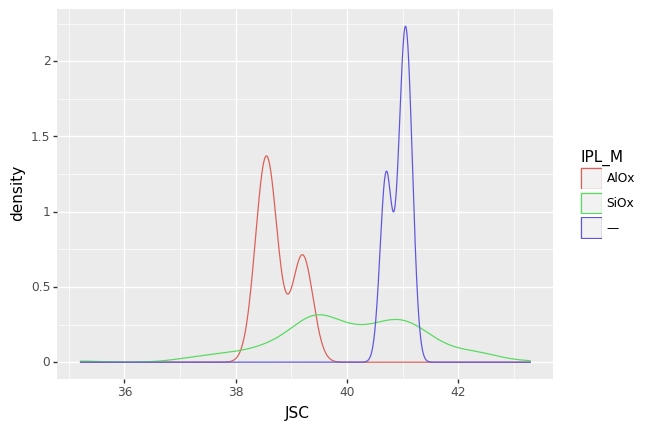

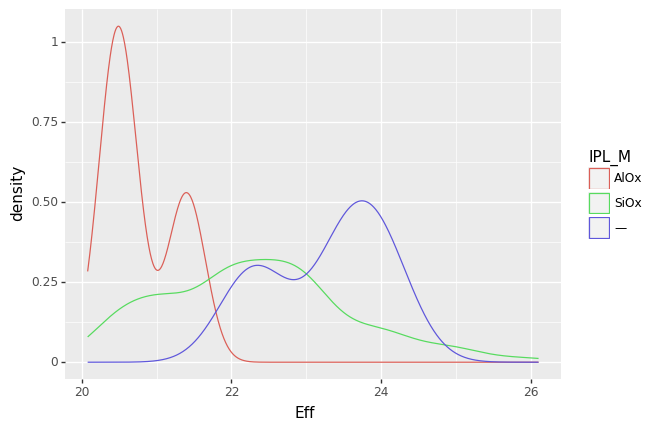

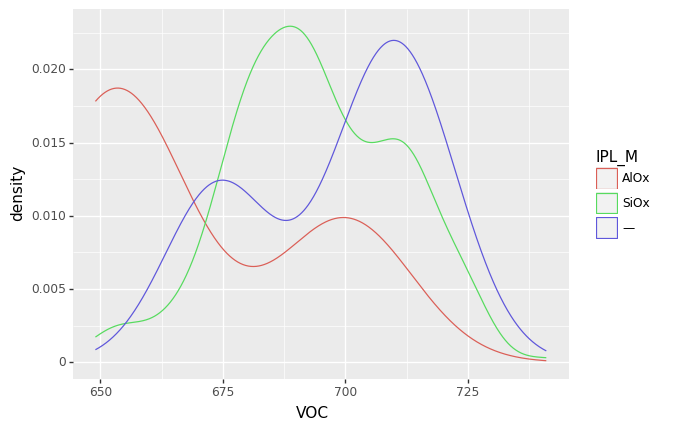

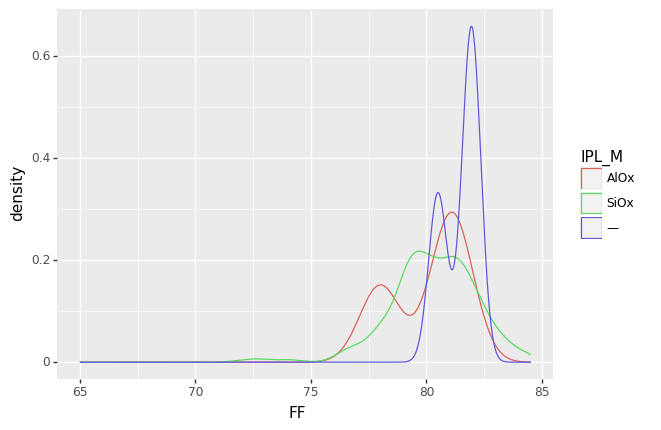

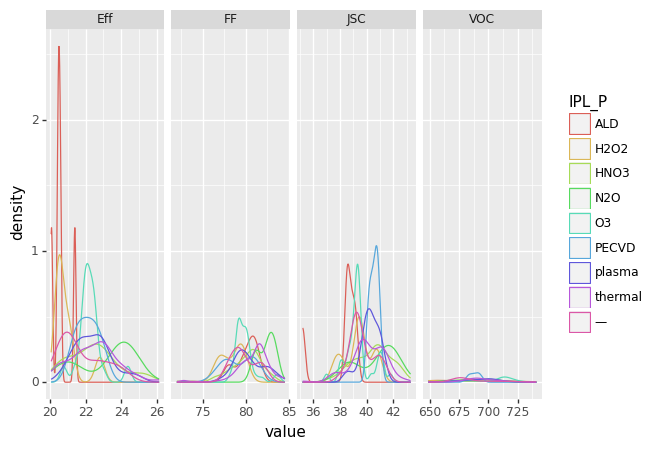

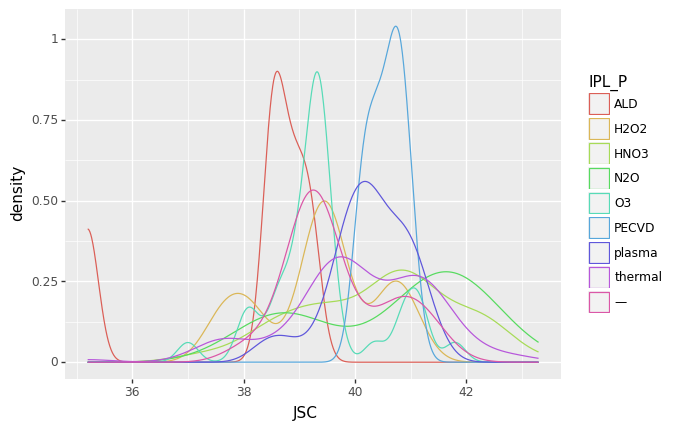

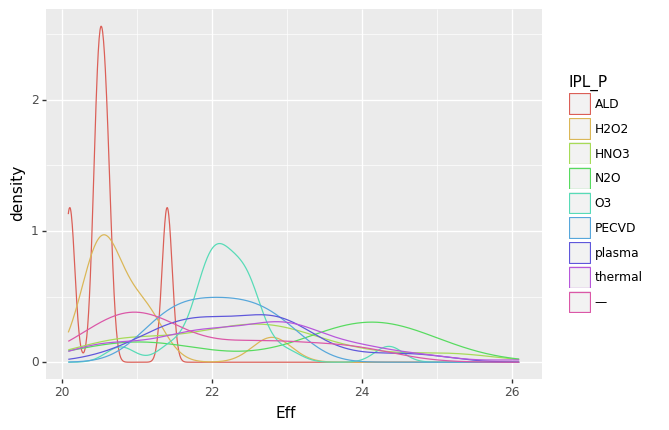

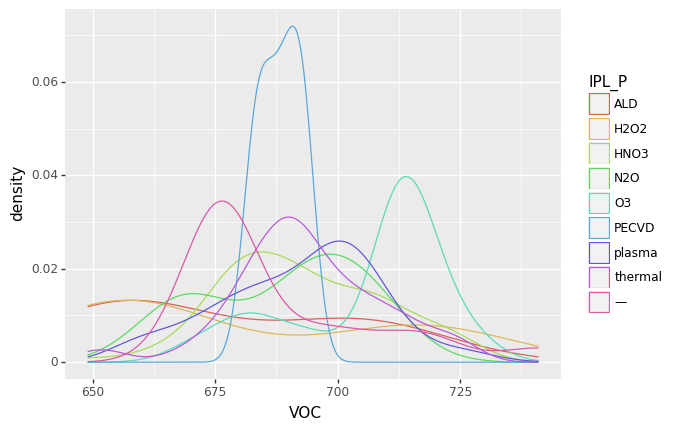

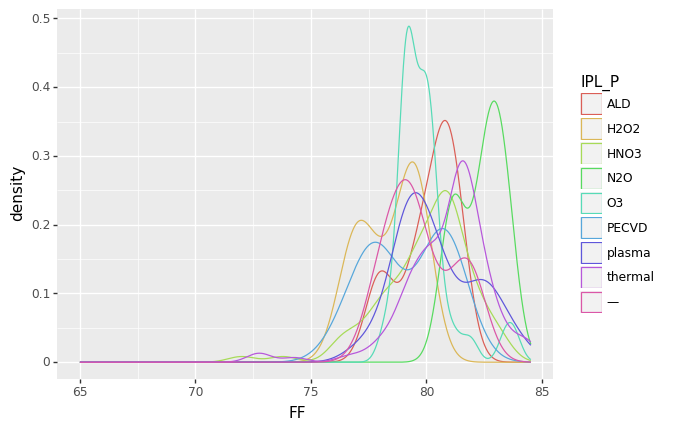

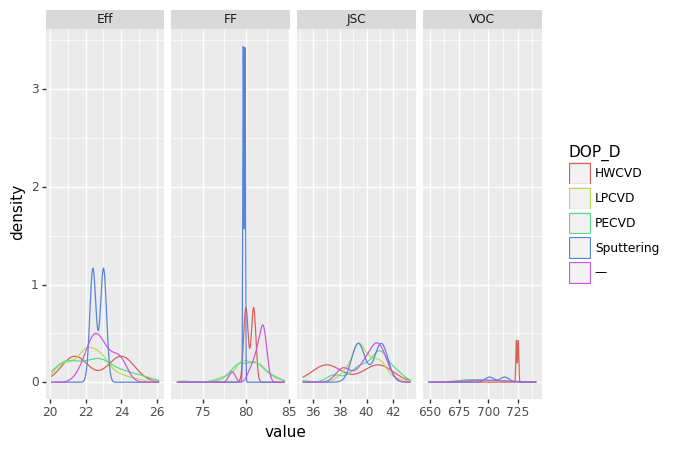

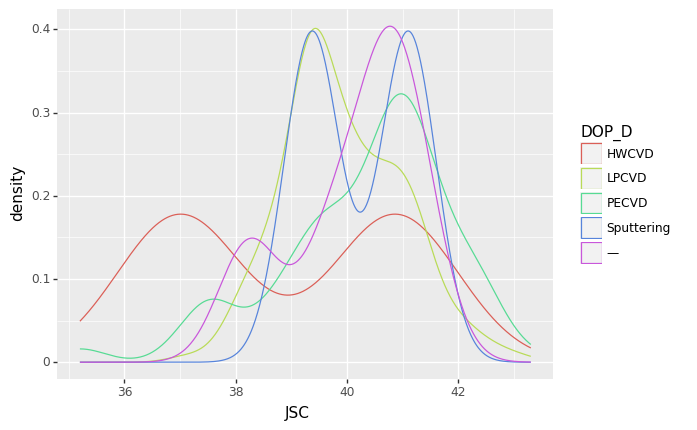

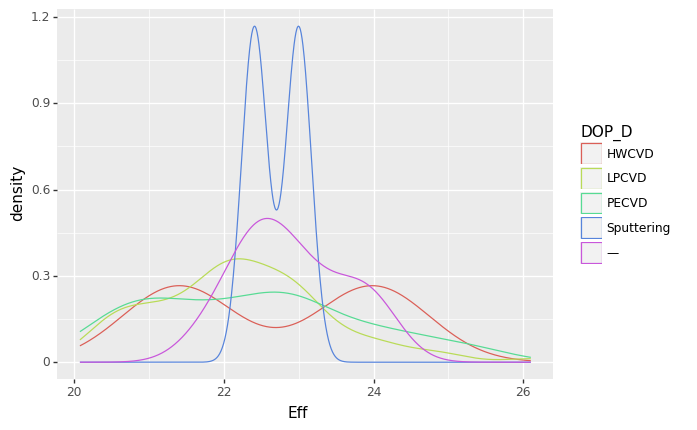

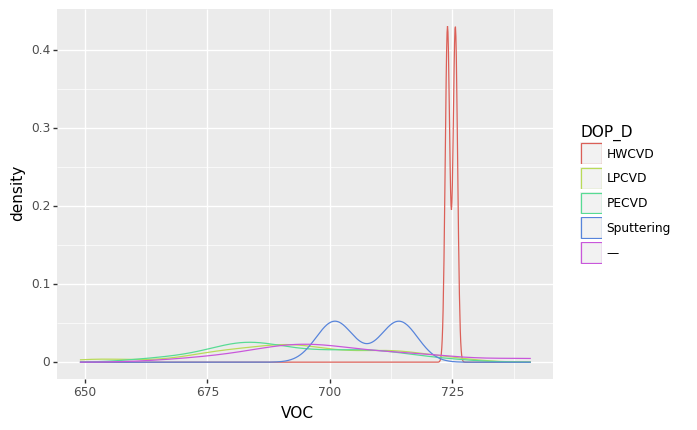

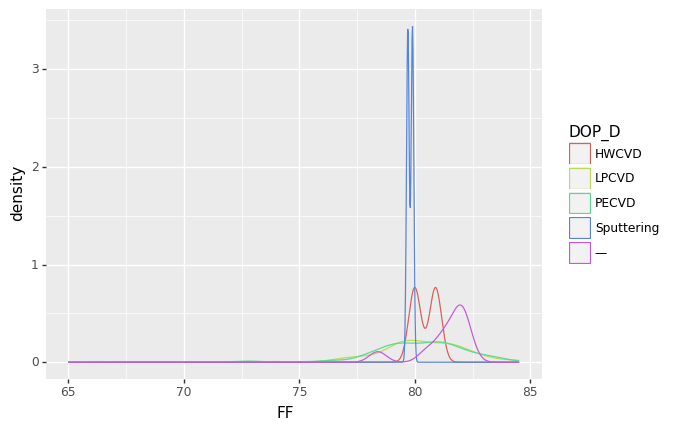

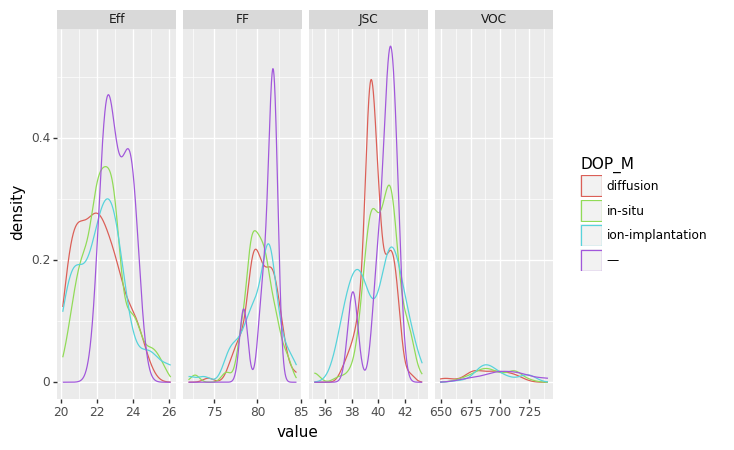

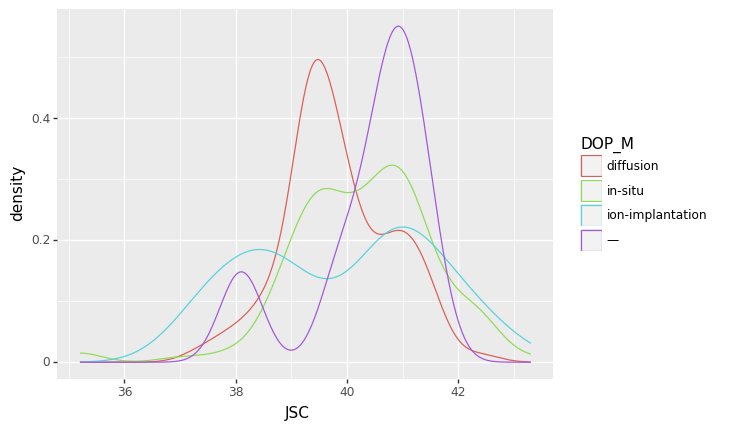

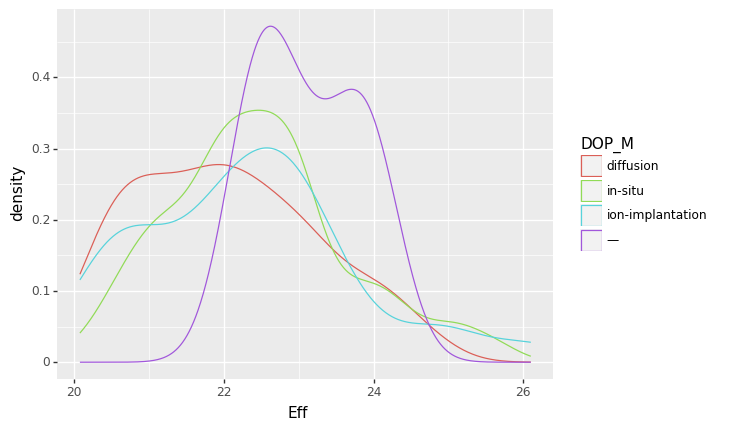

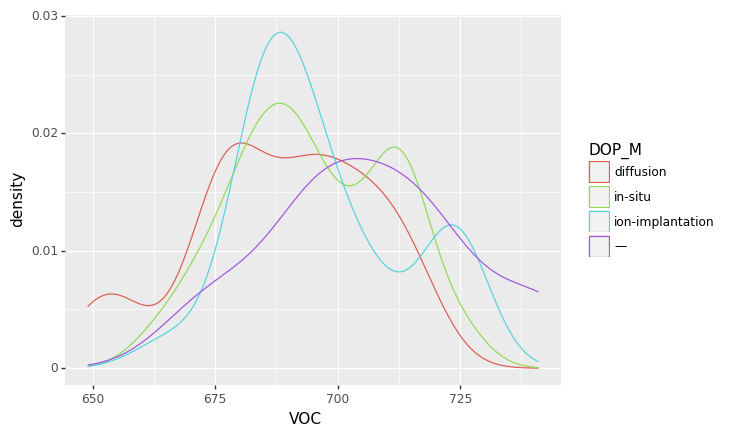

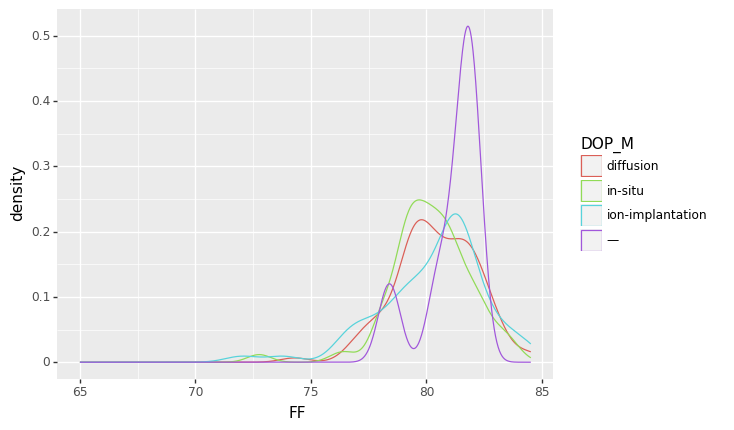

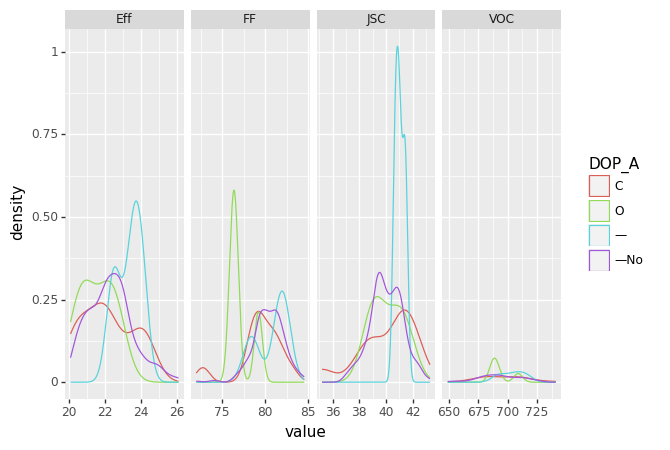

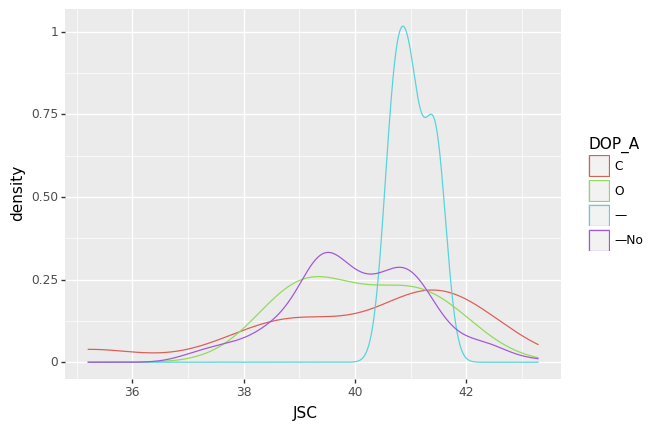

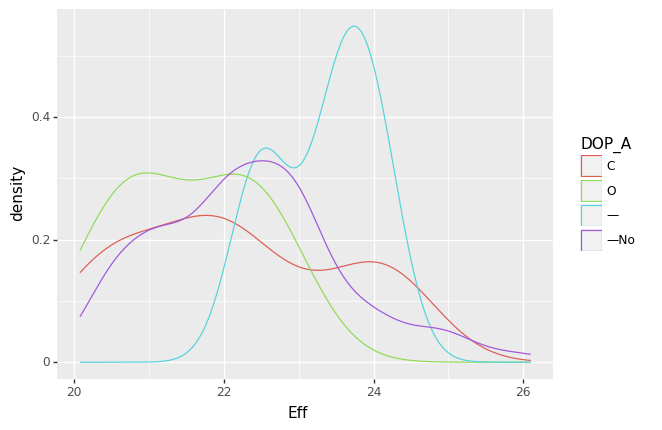

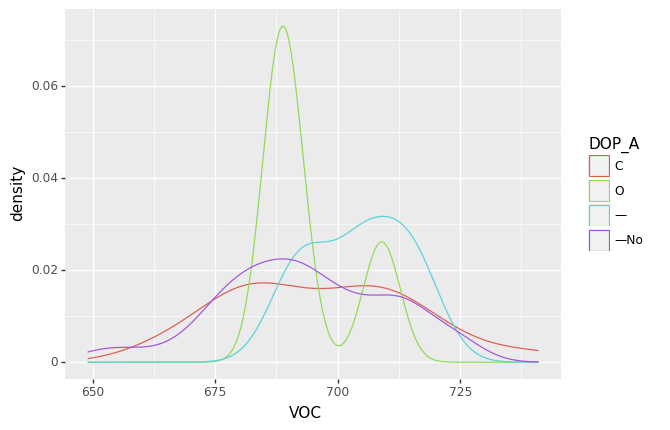

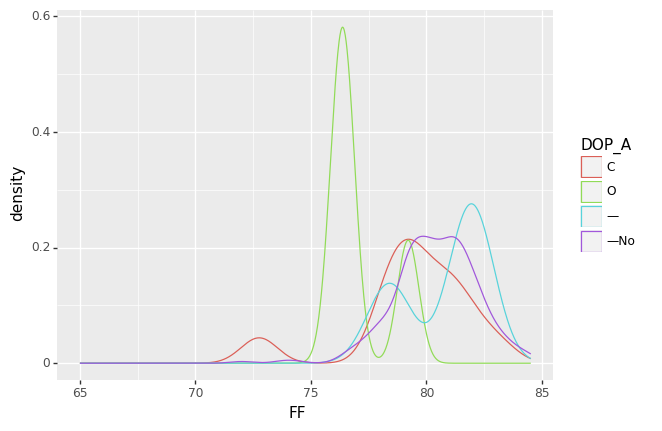

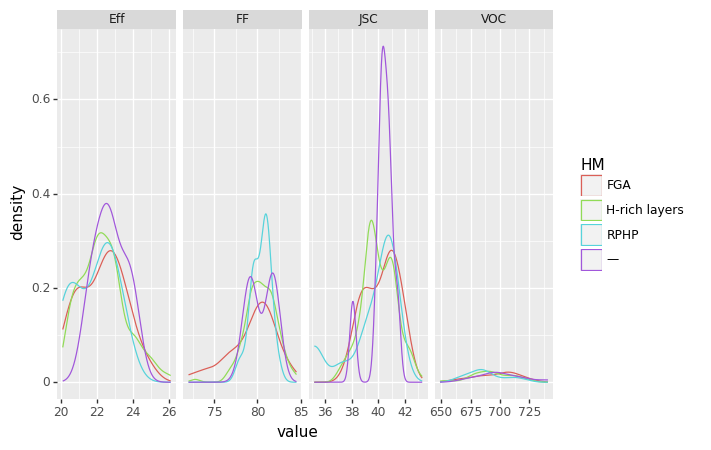

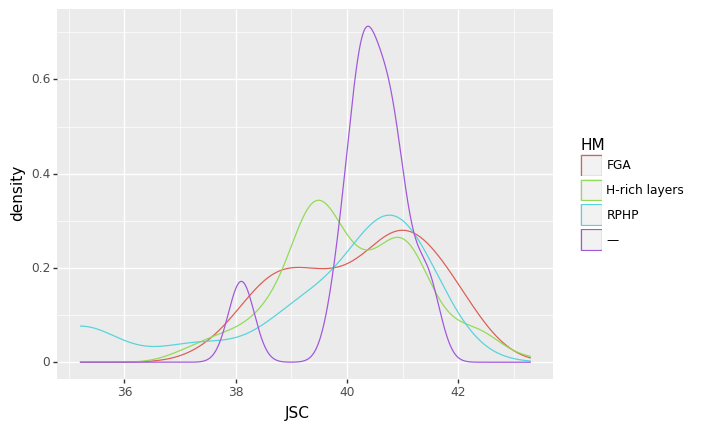

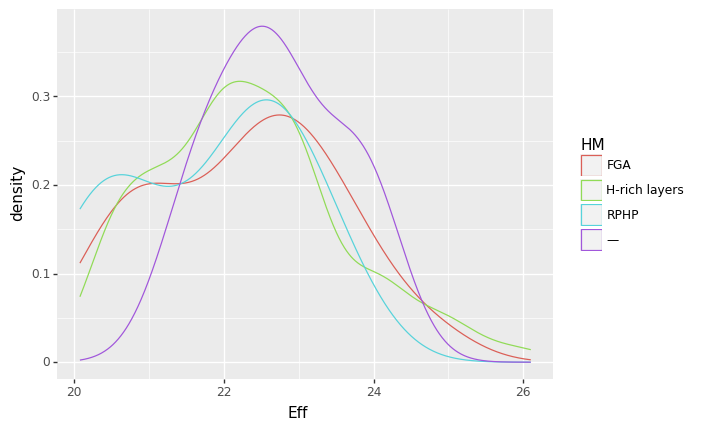

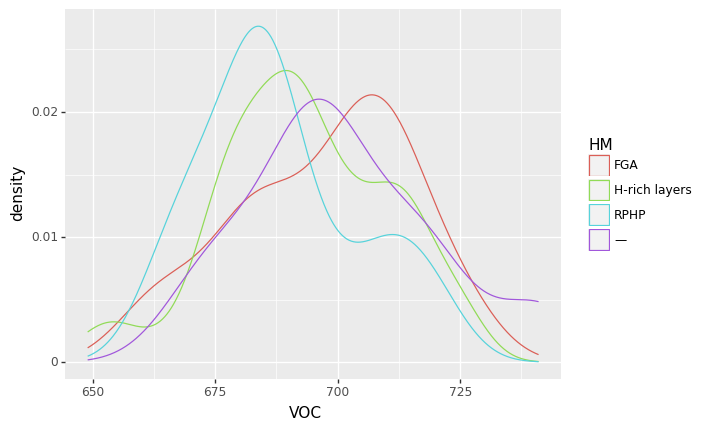

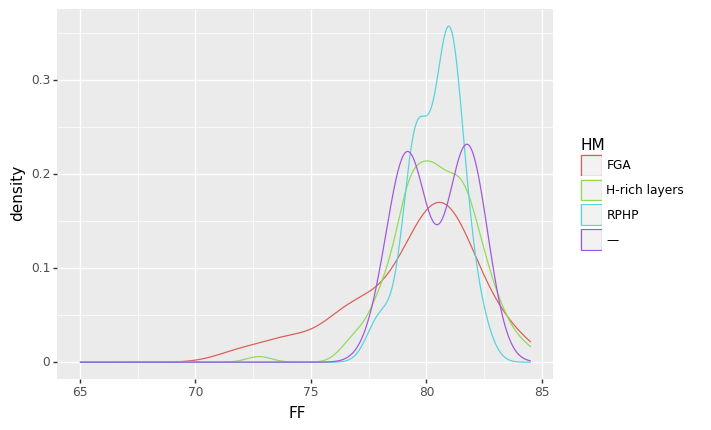

In [8]:
#Analysis of the relationship between category independent variable and dependent variable
discrete_cols=['CT','PN','IBC','DS','CSI_O','CSI_G','IPL_M',
               'IPL_P','DOP_D','DOP_M','DOP_A','HM']
df_long=pd.melt(df,id_vars=discrete_cols,value_vars=['VOC', 'JSC', 'FF', 'Eff'])
#df_long.head()
for c in discrete_cols:        
    print(ggplot(df_long,aes("value"))+geom_density(aes(colour=c))+facet_grid('~variable',scales='free'))
    print(ggplot(df,aes('JSC'))+geom_density(aes(colour=c)))
    print(ggplot(df,aes('Eff'))+geom_density(aes(colour=c)))
    print(ggplot(df,aes('VOC'))+geom_density(aes(colour=c)))
    print(ggplot(df,aes('FF'))+geom_density(aes(colour=c))+xlim(65,np.nan))

# Feature engineering

In [9]:
X=df.drop(columns=['VOC','JSC','FF','Eff']).copy()
#z-score standardization of numerical variables
num_cols=['CSI_T','CSI_R','IPL_T','DOP_T','AT']
X[num_cols]=StandardScaler().fit_transform(X[num_cols])

#one-hot encoding of discrete variables
X=pd.get_dummies(X,drop_first=True)
y1=df['VOC']
y2=df['JSC']
y3=df['FF']
y4=df['Eff']

In [10]:
#trainset(75%),testset(25%)
X_train1,X_test1,y_train1,y_test1=train_test_split(X,y1,test_size=0.25,random_state=1)
X_train2,X_test2,y_train2,y_test2=train_test_split(X,y2,test_size=0.25,random_state=1)
X_train3,X_test3,y_train3,y_test3=train_test_split(X,y3,test_size=0.25,random_state=1)
X_train4,X_test4,y_train4,y_test4=train_test_split(X,y4,test_size=0.25,random_state=1)


# Modeling

In [11]:
#Define a model training and prediction function
def train_predict(X_train=X_train1,X_test=X_test1,y_train=y_train1,y_test=y_test1,
                  response_variable='VOC',
                  base_estimators=['lasso','rf','bp']):    

    ###Lasso
    print('----------------------------Lasso-----------------------------------')
    lasso=Lasso()
    #Define the hyperparameter search range
    param1={'alpha':[1e-3,1e-2,1e-1,1,1e1,1e2,1e3]}

    # 5-fold cross validation
    reg1=GridSearchCV(lasso,param1,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg1.fit(X_train,y_train)

    #best paramemeters
    print(reg1.best_params_)
    #rmse
    print(-reg1.best_score_)
    
    ###RandomForest
    print('-----------------------------RandomForest-----------------------------------')
    #Define the hyperparameter search range
    param2={'n_estimators':range(100,600,50),
           'max_depth':range(5,15)}
    rf=RandomForestRegressor(random_state=0)
    # 5-fold cross validation
    reg2=GridSearchCV(rf,param2,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg2.fit(X_train,y_train)

    #best paramemeters
    print(reg2.best_params_)
    #rmse
    print(-reg2.best_score_)


    #Feature importance
    print('---------------Feature importance-----------------')
    feature_importance=pd.Series(reg2.best_estimator_.feature_importances_,index=X_train.columns)
    #Sort the importance of features
    importance=feature_importance.sort_values(ascending=False)
    print(importance)
    #bar plot
    print(importance[:10].plot.barh())

    ###BP Neural Network
    print('-----------------------------BP Neural Network-----------------------------------')
    #Define the hyperparameter search range
    param3={'hidden_layer_sizes':[(50,),(100),(50,50),(100,100)],
            'alpha':[1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06]}
    mlp=MLPRegressor(random_state=1,max_iter=1000)
    # 5-fold cross validation
    reg3=GridSearchCV(mlp,param3,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg3.fit(X_train,y_train)

    #best paramemeters
    print(reg3.best_params_)
    #rmse
    print(-reg3.best_score_)

    ###Stacking 
    estimators_all= {'lasso':('lasso',reg1),
                'rf':('rf',reg2),
                'bp':('bp',reg3)}
    
    reg4=StackingRegressor(estimators=[estimators_all[m] for m in base_estimators],
                           final_estimator=RidgeCV())
    reg4.fit(X_train,y_train)
    #Model performance comparison
    print('-----------------------------Model performance comparison-----------------------------------')
    models=[reg1,reg2,reg3,reg4]
    #r2 socre
    r2=[]
    #mae
    mae=[]
    #rmse
    rmse=[]
    #mape
    mape=[]

    for model in models:
        pred_test=model.predict(X_test)    
        r2.append(r2_score(y_test,pred_test))
        mae.append(mean_absolute_error(y_test,pred_test))
        rmse.append(mean_squared_error(y_test,pred_test,squared=False))
        mape.append(mean_absolute_percentage_error(y_test,pred_test))


    #Combine the results into data frame
    compare=pd.DataFrame({'r2':r2,
                         'mae':mae,
                         'rmse':rmse,
                         'mape':mape},index=['lasso','rf','bp','stacking'])
    print(compare)

    #Output a comparison between the actual value and the predicted value
    df_compare=X_test.copy()
    df_compare[response_variable]=y_test
    df_compare[response_variable+'_lasso_pred']=reg1.predict(X_test)
    df_compare[response_variable+'_rf_pred']=reg2.predict(X_test)
    df_compare[response_variable+'_ann_pred']=reg3.predict(X_test)
    df_compare[response_variable+'_stacking_pred']=reg4.predict(X_test)
    df_compare.to_excel("df_compare_{}.xlsx".format(response_variable))
    
    

----------------------------Lasso-----------------------------------
{'alpha': 10.0}
17.984745422705753
-----------------------------RandomForest-----------------------------------
{'max_depth': 14, 'n_estimators': 300}
13.448983325518682
---------------Feature importance-----------------
CSI_R                     0.229349
DOP_T                     0.184813
CSI_T                     0.090209
AT                        0.084574
IPL_T                     0.061895
CT_p                      0.049990
CSI_G_FZ                  0.041756
CSI_O_—                   0.024659
PN_Rear                   0.021903
IPL_P_O3                  0.019139
HM_RPHP                   0.015253
CSI_G_—                   0.014974
DOP_D_PECVD               0.013461
DOP_M_—                   0.013335
IBC_Yes                   0.013092
DS_Yes                    0.012493
DOP_M_in-situ             0.010638
IPL_P_thermal             0.010518
DOP_M_ion-implantation    0.010489
HM_H-rich layers          0.010350
DOP_A_—No 

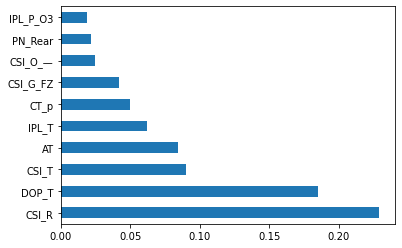

In [12]:
#VOC
train_predict(X_train=X_train1,X_test=X_test1,y_train=y_train1,y_test=y_test1,response_variable='VOC')

----------------------------Lasso-----------------------------------
{'alpha': 0.01}
1.1970359378481317
-----------------------------RandomForest-----------------------------------
{'max_depth': 14, 'n_estimators': 400}
0.9636702856302648
---------------Feature importance-----------------
DOP_T                     0.167069
DS_Yes                    0.156967
CSI_T                     0.131198
CSI_R                     0.088670
AT                        0.086545
IPL_T                     0.053503
HM_RPHP                   0.045225
PN_Rear                   0.035780
DOP_D_PECVD               0.029757
CSI_G_FZ                  0.024123
IPL_P_O3                  0.019050
DOP_M_ion-implantation    0.017644
CT_p                      0.016405
DOP_D_LPCVD               0.016040
HM_H-rich layers          0.015395
CSI_O_—                   0.014819
DOP_A_—No                 0.013230
IPL_P_HNO3                0.011215
IBC_Yes                   0.010901
IPL_P_thermal             0.009668
CSI_G_—   

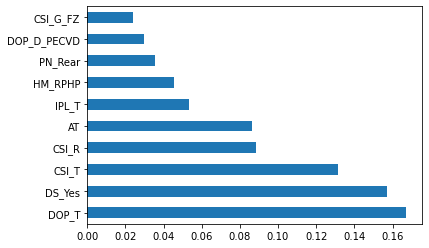

In [13]:
#JSC
train_predict(X_train=X_train2,X_test=X_test2,y_train=y_train2,y_test=y_test2,response_variable='JSC')

----------------------------Lasso-----------------------------------
{'alpha': 1}
1.8813546324638035
-----------------------------RandomForest-----------------------------------
{'max_depth': 11, 'n_estimators': 300}
1.6609835045701644
---------------Feature importance-----------------
CSI_T                     0.217256
CSI_R                     0.211859
DOP_T                     0.148583
AT                        0.084921
CSI_G_—                   0.053424
IPL_T                     0.041885
IPL_P_thermal             0.024553
PN_Rear                   0.020049
CSI_O_—                   0.018333
DOP_A_O                   0.017968
DOP_M_ion-implantation    0.017341
IPL_P_H2O2                0.014655
IPL_P_HNO3                0.014377
HM_H-rich layers          0.011209
DOP_A_—No                 0.010221
DOP_M_in-situ             0.009835
IPL_P_N2O                 0.009437
IPL_P_plasma              0.008684
CT_p                      0.008157
DS_Yes                    0.007119
DOP_D_LPCVD  

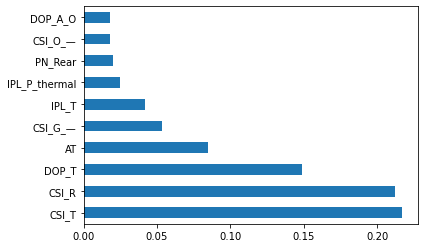

In [14]:
#FF
train_predict(X_train=X_train3,X_test=X_test3,y_train=y_train3,y_test=y_test3,response_variable='FF')

----------------------------Lasso-----------------------------------
{'alpha': 0.1}
1.2855272169341745
-----------------------------RandomForest-----------------------------------
{'max_depth': 13, 'n_estimators': 200}
0.9025572433075968
---------------Feature importance-----------------
CSI_R                     0.245622
CSI_T                     0.202093
DOP_T                     0.152439
AT                        0.075461
IPL_T                     0.045694
HM_RPHP                   0.028135
PN_Rear                   0.022606
DOP_A_—No                 0.021824
DOP_D_PECVD               0.021304
CSI_O_—                   0.020483
IBC_Yes                   0.019458
CSI_G_FZ                  0.013343
CSI_G_—                   0.012374
DOP_M_—                   0.011580
DOP_M_in-situ             0.010449
IPL_P_HNO3                0.009938
DOP_D_—                   0.009550
IPL_P_thermal             0.009549
CT_p                      0.009028
DOP_D_LPCVD               0.008527
DS_Yes     

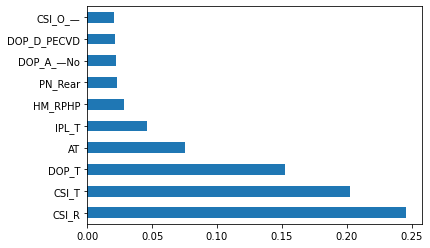

In [15]:
#Efficiency
train_predict(X_train=X_train4,X_test=X_test4,y_train=y_train4,y_test=y_test4,response_variable='Efficiency')

# Efficiency Comparison between the real value and the predicted value

Text(0, 0.5, 'stacking_pred')

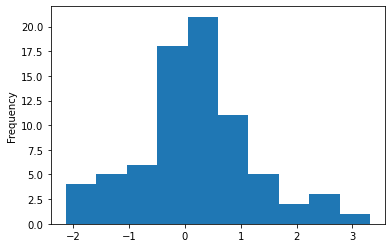

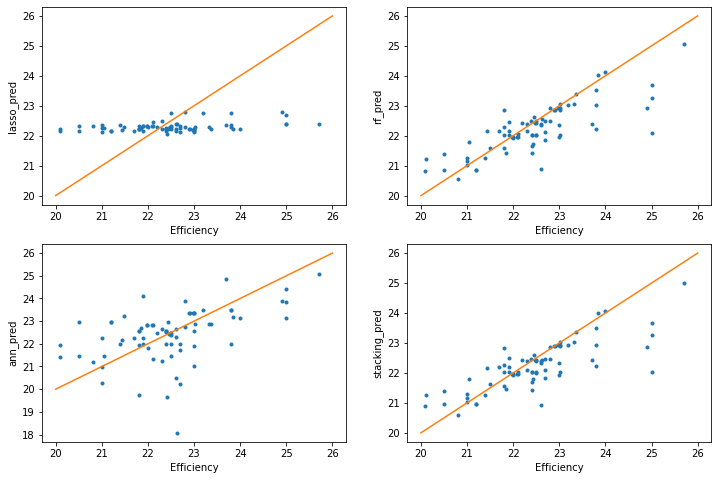

In [16]:

#Efficiency
df_compare_Efficiency=pd.read_excel('df_compare_Efficiency.xlsx',index_col=0)

(df_compare_Efficiency['Efficiency']-df_compare_Efficiency['Efficiency_lasso_pred']).plot.hist()

plt.rc('figure', figsize=(12, 8))
fig,ax=plt.subplots(2,2)
ax[0,0].plot('Efficiency','Efficiency_lasso_pred','.',data=df_compare_Efficiency)
ax[0,0].plot([20,26],[20,26])
ax[0,0].set_xlabel("Efficiency")
ax[0,0].set_ylabel("lasso_pred")
ax[0,1].plot('Efficiency','Efficiency_rf_pred','.',data=df_compare_Efficiency)
ax[0,1].plot([20,26],[20,26])
ax[0,1].set_xlabel("Efficiency")
ax[0,1].set_ylabel("rf_pred")
ax[1,0].plot('Efficiency','Efficiency_ann_pred','.',data=df_compare_Efficiency)
ax[1,0].plot([20,26],[20,26])
ax[1,0].set_xlabel("Efficiency")
ax[1,0].set_ylabel("ann_pred")
ax[1,1].plot('Efficiency','Efficiency_stacking_pred','.',data=df_compare_Efficiency)
ax[1,1].plot([20,26],[20,26])
ax[1,1].set_xlabel("Efficiency")
ax[1,1].set_ylabel("stacking_pred")

# Decision Tree

In [17]:
#对类别变量进行one-hot编码
X2=pd.get_dummies(df.drop(columns=['VOC','JSC','FF','Eff']).copy(),drop_first=True)
def dt_plot(X=X2,y=y1):
    #Set the hyperparameter search range
    param={'max_depth':range(2,20)}
    dt=DecisionTreeRegressor(random_state=0)
    #5-fold cross validation
    reg=GridSearchCV(dt,param,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg.fit(X,y)

    #plot_tree 
    fig,ax=plt.subplots(1,1,figsize=[24,14])
    _=plot_tree(reg.best_estimator_,          
              fontsize=12,
              ax=ax,
              feature_names=X.columns,
              filled=True,
              impurity=True,
             rounded=True)

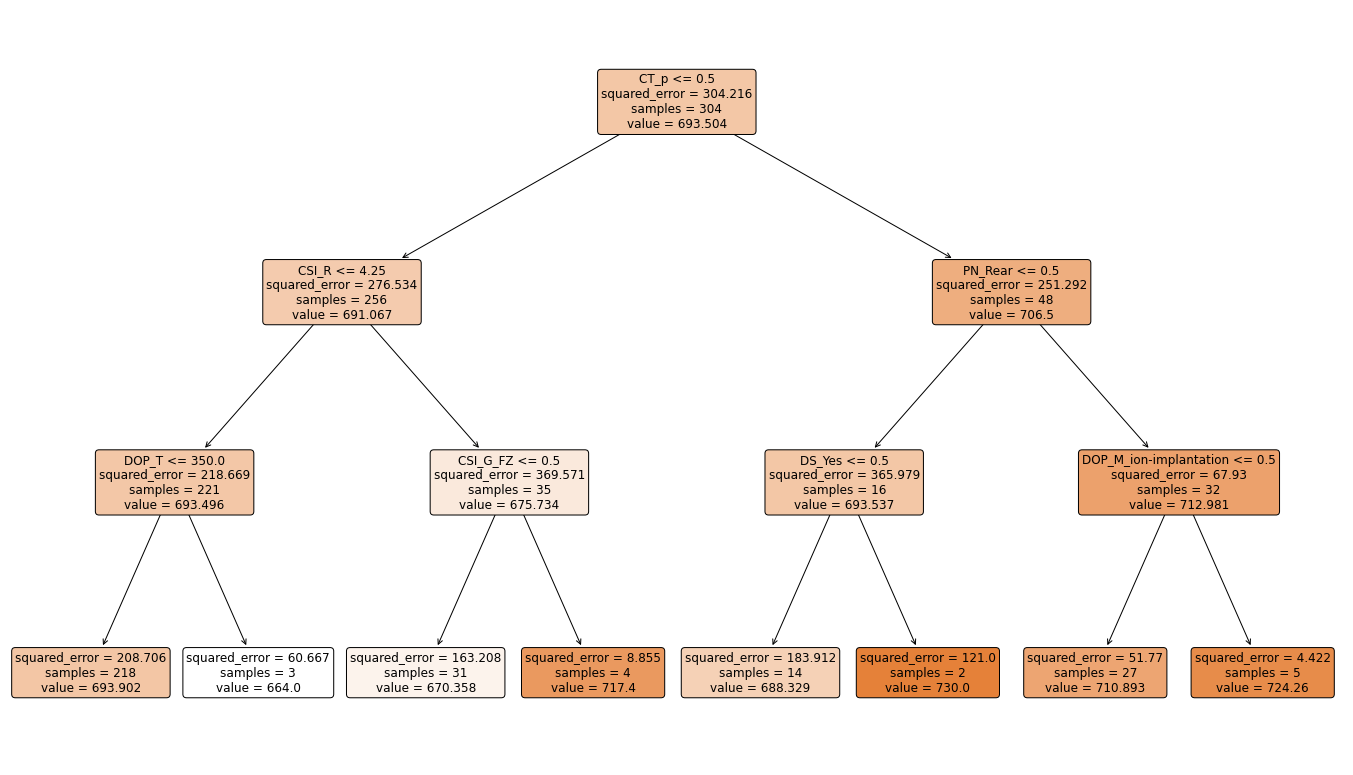

In [18]:
#VOC
dt_plot(X2,y1)


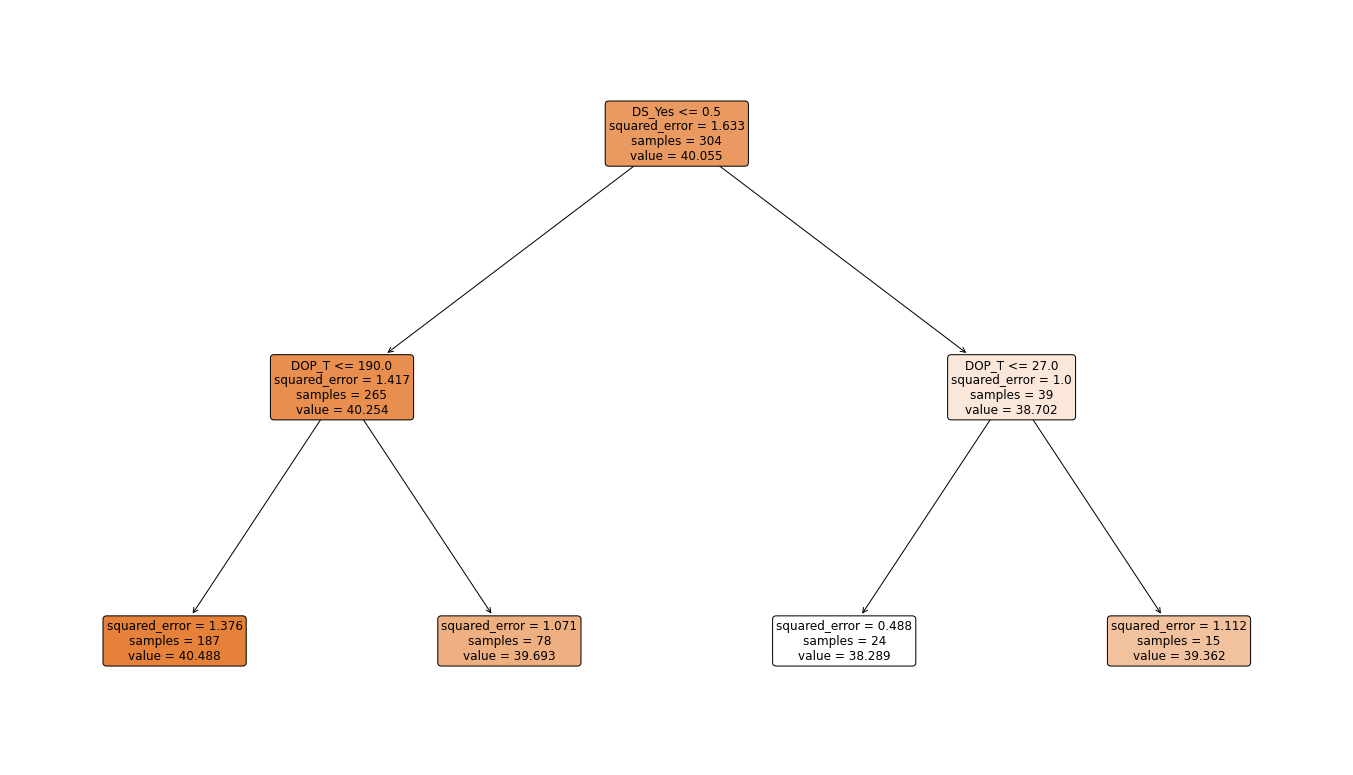

In [19]:
#JSC
dt_plot(X2,y2)

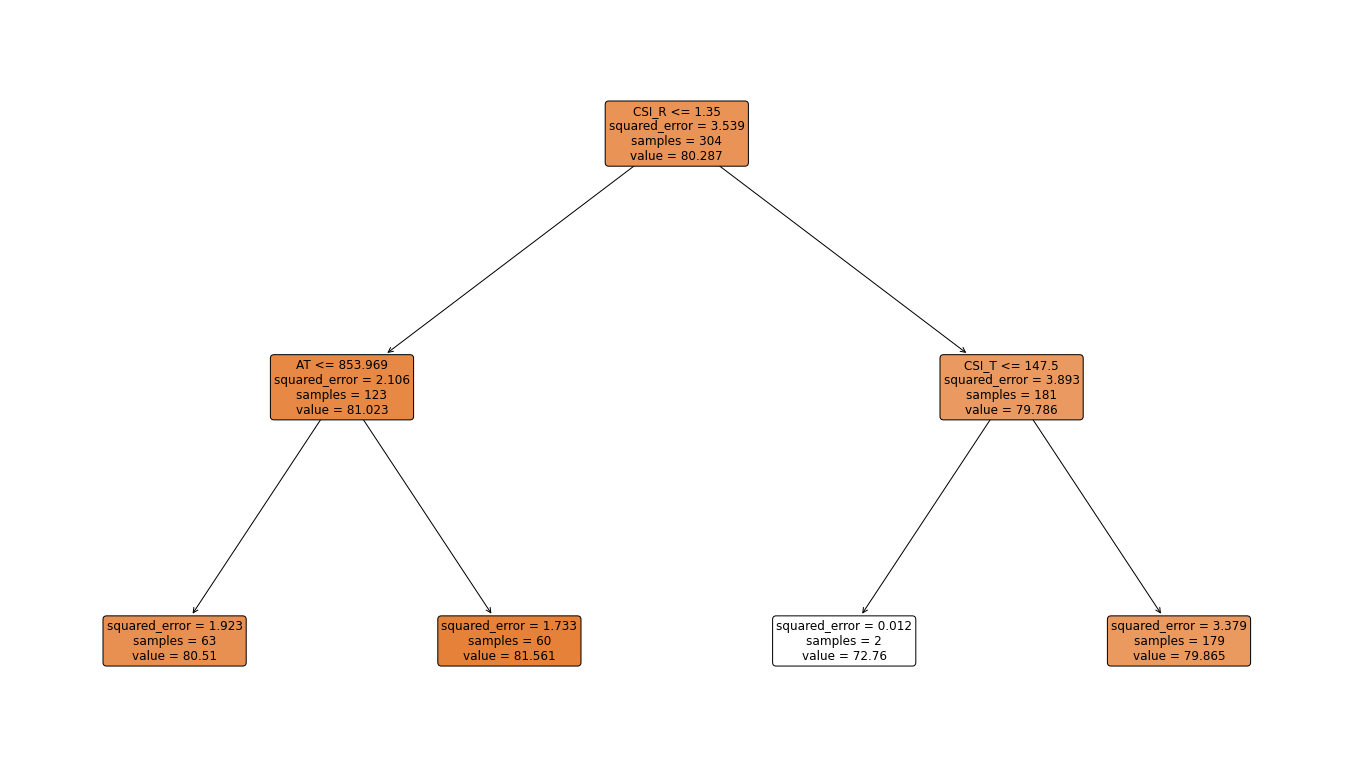

In [20]:
#FF
dt_plot(X2,y3)

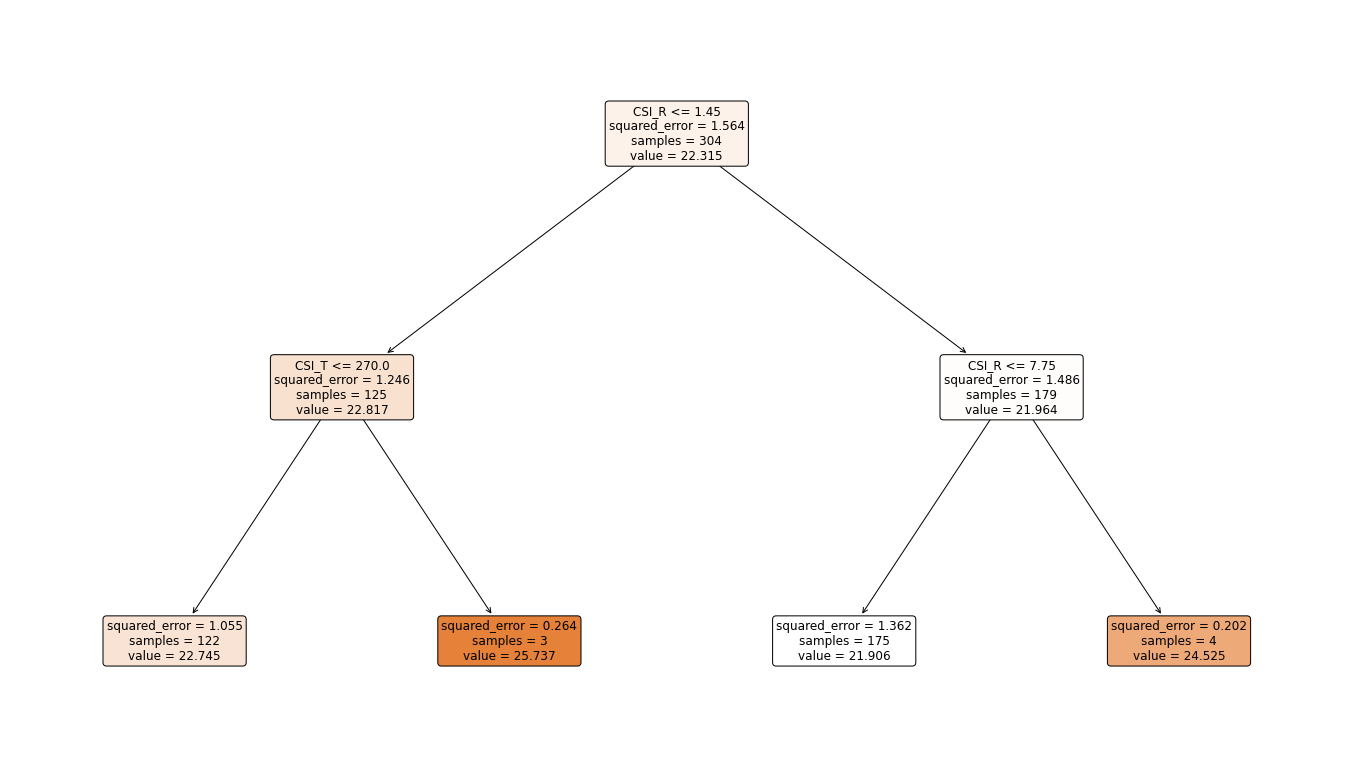

In [21]:
#Efficiency
dt_plot(X2,y4)

# SHAP

In [22]:

def train_predict_shap(X_train=X_train1,X_test=X_test1,y_train=y_train1,y_test=y_test1): 
    ###RandomForest
    print('-----------------------------RandomForest-----------------------------------')
    #Set the hyperparameter search range
    param={'n_estimators':range(100,600,50),
           'max_depth':range(5,15)}
    rf=RandomForestRegressor(random_state=0)
    # 5-fold cross validation
    reg=GridSearchCV(rf,param,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg.fit(X_train,y_train)

    model=reg.best_estimator_      
    #shap 
    print("Feature importance graph based on shap value:")
    explainer=shap.TreeExplainer(model,data=X_train)
    
    shap_values=explainer.shap_values(X_train)
    #shap_values2=explainer(X)
    
    #Feature importance graph based on shap value
    shap.summary_plot(shap_values,feature_names=X_train.columns,plot_type="bar")    
    shap.summary_plot(shap_values, features=X_train)

-----------------------------RandomForest-----------------------------------
Feature importance graph based on shap value:


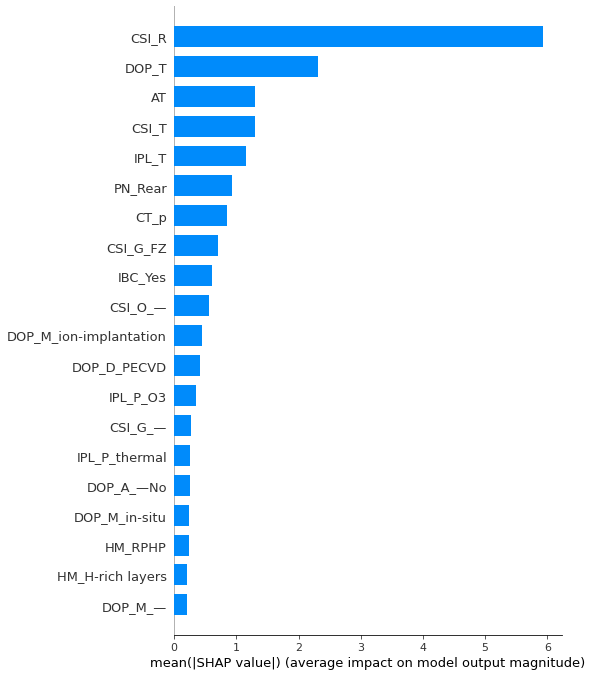

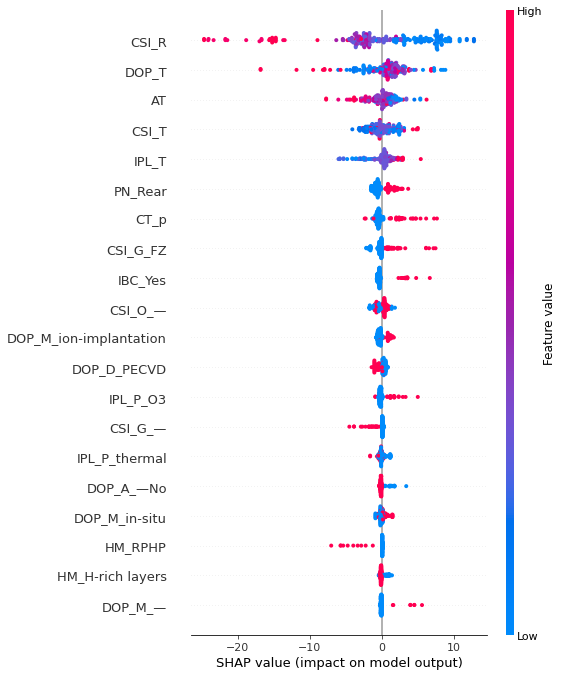

In [23]:
#VOC
train_predict_shap(X_train=X_train1,X_test=X_test1,y_train=y_train1,y_test=y_test1)

-----------------------------RandomForest-----------------------------------
Feature importance graph based on shap value:


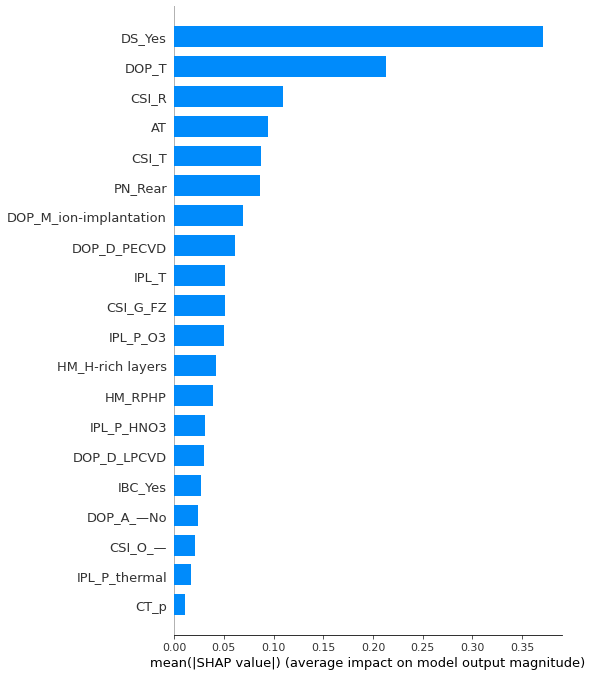

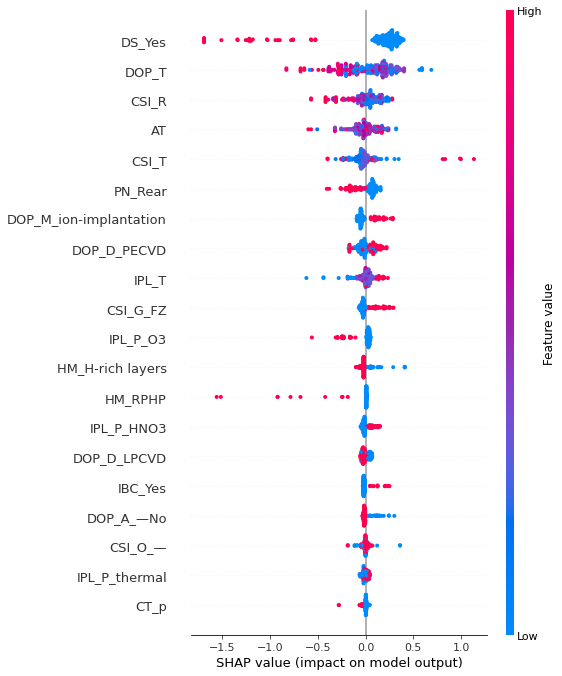

In [24]:
#JSC
train_predict_shap(X_train=X_train2,X_test=X_test2,y_train=y_train2,y_test=y_test2)

-----------------------------RandomForest-----------------------------------
Feature importance graph based on shap value:


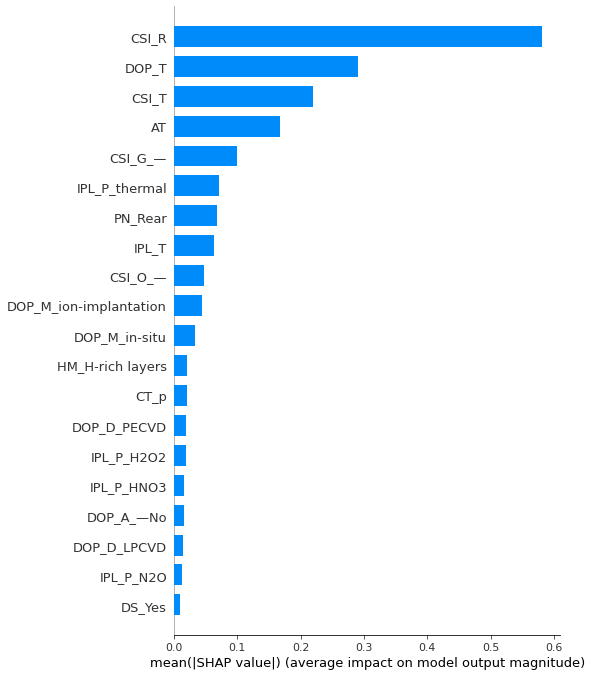

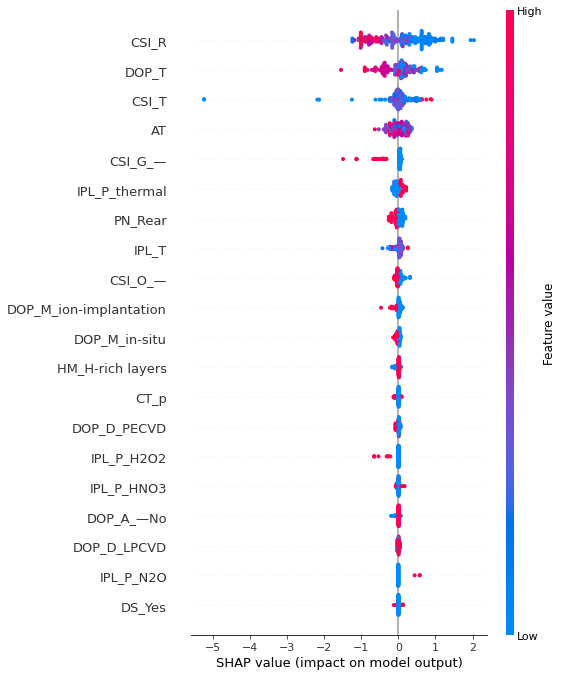

In [25]:
#FF
train_predict_shap(X_train=X_train3,X_test=X_test3,y_train=y_train3,y_test=y_test3)

-----------------------------RandomForest-----------------------------------
Feature importance graph based on shap value:


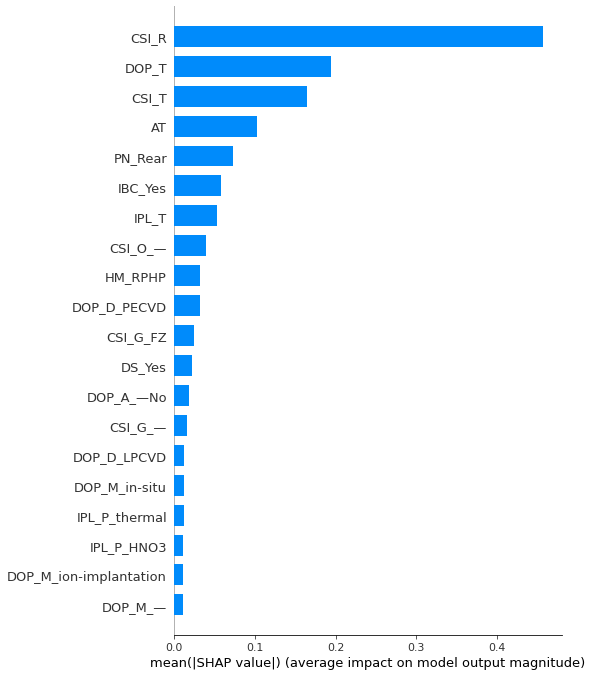

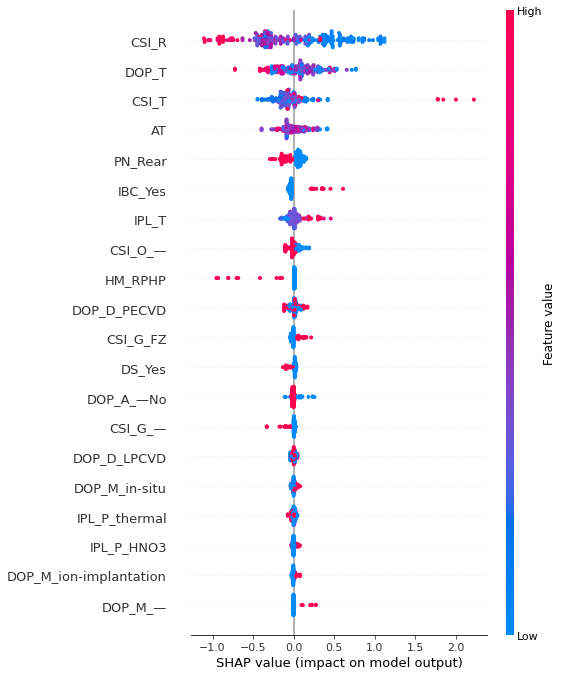

In [26]:
#Efficiency
train_predict_shap(X_train=X_train4,X_test=X_test4,y_train=y_train4,y_test=y_test4)

# Association rule

In [27]:

#Select discrete variables  and Efficiency variable
cols=discrete_cols+['Eff']
df2=df_eff_all[cols].copy()
#group efficiency variable
df2['Eff']=pd.cut(df2['Eff'],bins=[0,20,22,27],right=False).astype(str)
#add columns name
for col in df2.columns:
    df2[col]=col+'_'+df2[col]
#df2.head()

#transfor data to transaction type
transactions=[]
for i in range(len(df2)):
    transactions.append(tuple(df2.iloc[i]))
itemsets,rules=apriori(transactions,min_support=0.1,min_confidence=0.7)
len(rules)

166253

In [28]:
#left side
lhs=[]
#right side
rhs=[]
#support
support=[]
#length of rules
rule_len=[]
#confidence 
confidence=[]
#lift
lift=[]
count=[]
for rule in rules:    
    if 'Eff' in ''.join(rule.rhs) and  len(rule.rhs)==1:         
        lhs.append(rule.lhs)    
        rhs.append(rule.rhs)
        support.append(rule.support)
        rule_len.append(len(rule))
        confidence.append(rule.confidence)
        lift.append(rule.lift)  
        count.append(rule.count_full)

rules_df=pd.DataFrame({'lhs':lhs,
                       'rhs':rhs,
                       'support':support,
                       'confidence':confidence,
                       'lift':lift,
                       'count':count,
                       'rule_len':rule_len})
#sort by lift
rules_df.sort_values(by='lift',ascending=False,inplace=True)
rules_df.to_excel('rules_df_final.xlsx',index=False)
print(rules_df.shape)
rules_df

(60, 7)


,lhs,rhs,support,confidence,lift,count,rule_len
59,"(CSI_G_CZ, DOP_D_LPCVD, HM_H-rich layers, IBC_...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,8
27,"(CSI_G_CZ, CT_n, DOP_D_LPCVD, HM_H-rich layers...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,7
44,"(CSI_G_CZ, CT_n, DOP_A_—No, DOP_D_LPCVD, HM_H-...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,8
29,"(CSI_G_CZ, CT_n, DOP_D_LPCVD, IPL_M_SiOx, IPL_...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,7
45,"(CSI_G_CZ, CT_n, DOP_A_—No, DOP_D_LPCVD, IBC_N...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,8
46,"(CSI_G_CZ, CT_n, DOP_A_—No, DOP_D_LPCVD, IPL_M...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,8
20,"(CSI_G_CZ, CT_n, DOP_A_—No, DOP_D_LPCVD, IPL_P...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,7
39,"(CSI_G_CZ, DOP_D_LPCVD, HM_H-rich layers, IBC_...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,7
18,"(CSI_G_CZ, DOP_D_LPCVD, IPL_M_SiOx, IPL_P_ther...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,6
17,"(CSI_G_CZ, DOP_D_LPCVD, IBC_No, IPL_P_thermal,...","(Eff_[22, 27),)",0.129353,0.712329,1.590868,52,6


# Data fitting

## Data 1

In [29]:
#read dataset
df1=pd.read_excel('data.xlsx',sheet_name=0)
df2=pd.read_excel('data.xlsx',sheet_name=1)
df3=pd.read_excel('data.xlsx',sheet_name=2)

pce_limit=28.7
#data1
df1['y2']=np.log(pce_limit/df1['y']-1)
df1


,t,y,y2
0,2003.78,21.41,-1.077355
1,2006.28,21.76,-1.142772
2,2009.27,21.94,-1.177289
3,2010.41,24.22,-1.687556
4,2014.16,25.04,-1.923011
5,2015.84,25.17,-1.964355


In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#fit ols model
mod1=smf.ols(formula='y2~I(t-2000)',data=df1)
res1=mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     26.60
Date:                Thu, 30 Nov 2023   Prob (F-statistic):            0.00671
Time:                        16:25:20   Log-Likelihood:                 3.4886
No. Observations:                   6   AIC:                            -2.977
Df Residuals:                       4   BIC:                            -3.394
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.6636      0.175     -3.794      

a=0.5150
b=0.0835


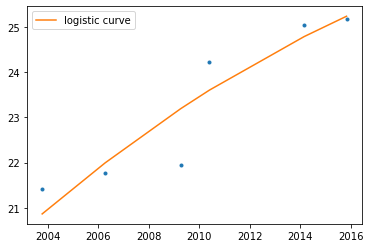

In [31]:
#a
plt.rc('figure', figsize=(6, 4))
a=np.exp(res1.params.iloc[0])
print('a={:.4f}'.format(a))
#b
b=-res1.params.iloc[1]
print('b={:.4f}'.format(b))
df1['fitted']=pce_limit/(1+a*np.exp(-b*(df1['t']-2000)))
fig,ax=plt.subplots(1,1)
ax.plot(df1['t'],df1['y'],'.')
ax.plot(df1['t'],df1['fitted'],'-',label='logistic curve')
ax.legend(loc='best')

## Data 2

In [32]:
df2['y2']=np.log(pce_limit/df2['y']-1)
df2.head()

,t,y,y2
0,2002.74,18.31,-0.566604
1,2009.97,19.10,-0.687925
2,2010.96,19.44,-0.741629
3,2010.96,19.61,-0.768865
4,2011.65,20.26,-0.875666


In [33]:
#fit ols model
mod2=smf.ols(formula='y2~I(t-2000)',data=df2)
res2=mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     187.6
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           6.11e-12
Time:                        16:25:20   Log-Likelihood:                 9.0647
No. Observations:                  23   AIC:                            -14.13
Df Residuals:                      21   BIC:                            -11.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2206      0.121      1.820      

a=1.2468
b=0.0986


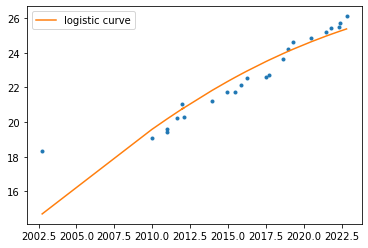

In [34]:
#a
plt.rc('figure', figsize=(6, 4))
a=np.exp(res2.params.iloc[0])
print('a={:.4f}'.format(a))
#b
b=-res2.params.iloc[1]
print('b={:.4f}'.format(b))
df2['fitted']=pce_limit/(1+a*np.exp(-b*(df2['t']-2000)))
fig,ax=plt.subplots(1,1)
ax.plot(df2['t'],df2['y'],'.')
ax.plot(df2['t'],df2['fitted'],'-',label='logistic curve')
ax.legend(loc='best')

## Data 3

In [35]:
df3['y2']=np.log(pce_limit/df3['y']-1)
df3.head()

,t,y,y2
0,2002.18,17.45,-0.438972
1,2003.18,17.53,-0.450682
2,2005.68,18.05,-0.527586
3,2008.17,18.60,-0.610626
4,2009.54,19.03,-0.676988


In [36]:
#fit ols model
mod3=smf.ols(formula='y2~I(t-2000)',data=df3)
res3=mod3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     234.8
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           3.05e-09
Time:                        16:25:20   Log-Likelihood:                 16.287
No. Observations:                  14   AIC:                            -28.57
Df Residuals:                      12   BIC:                            -27.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.1916      0.050     -3.843      

a=0.8256
b=0.0570


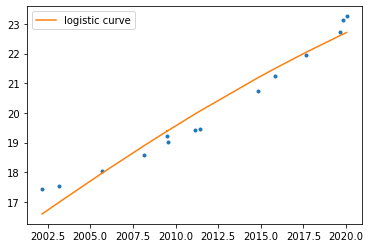

In [37]:
#a
plt.rc('figure', figsize=(6, 4))
a=np.exp(res3.params.iloc[0])
print('a={:.4f}'.format(a))
#b
b=-res3.params.iloc[1]
print('b={:.4f}'.format(b))
df3['fitted']=pce_limit/(1+a*np.exp(-b*(df3['t']-2000)))
fig,ax=plt.subplots(1,1)
ax.plot(df3['t'],df3['y'],'.')
ax.plot(df3['t'],df3['fitted'],'-',label='logistic curve')
ax.legend(loc='best')